 # Introdução

O objetivo desse notebook é criar um modelo de predição de gorjetas para as corridas de táxi de Chicago. A base de dados utilizada foi a [Chicago Taxi Trips](https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew), por ser uma base de dados grande vai ser utilizado PySpark para o tratamento dos dados e criação do modelo de machine learning (**ML**).

## Colunas da base utilizadas como entrada

As colunas utilizadas como entrada para modelo de ML desenvolvido vão ser:
* **Trip Start Timestamp**, a partir dela vai ser derivada a coluna trip_start_hour
* **Trip End Timestamp**, a partir dela vai ser derivada a coluna trip_end_hour
* **Pickup Community Area**, apenas as 11 áreas  mais frequentes vão ter o nome mantido as outras vão receber o nome m1
* **Dropoff Community Area**, apenas as 11 áreas  mais frequentes vão ter o nome mantido as outras vão receber o nome m1
* **Company**,  apenas as 19 companias mais frequentes vão ter o nome mantido, as outras vão receber nome m1
* **Payment type**
* Trip miles
* Trip seconds
* Fare
* Tolls
* Extras

As colunas em negrito são de dados discretos. Esses dados passaram por um processo de pivoteamento, para que assim sejam criadas colunas númericas a partir destas.

## Modelo de Machine learning utilizado

O modelo de machine learning utilizado vai ser decido com base nas métricas alcançadas pela criação automatizada de vários modelos de ML, utilizando o **Pycaret**, em uma pequena amostra da base de dados. Apenas 1% da base foi utilizada como amostra por questões de recursos computacionais, isso corresponde a um pouco mais que 160 mil registros de corridas de táxi.

# Configuração do ambiente

Download dos pacotes necessarios


In [41]:
import os

os.system('pip install --upgrade google-cloud-bigquery')
os.system('pip install pyspark')
os.system('pip install pandas')
os.system('pip install pycaret')
os.system('pip install shap')

Requirement already up-to-date: google-cloud-bigquery in /home/kite/.local/lib/python3.8/site-packages (3.4.1)


0

 Carregamento dos pacotes

In [5]:
import os
import pandas as pd
from pyspark.sql import SparkSession
import pyspark
import re
from pyspark.sql.functions import col, udf
import time
import datetime
import pyspark.sql.functions as F
from pyspark.sql.functions import expr
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.tree import RandomForest
from pyspark.ml.regression import RandomForestRegressor
import pycaret
import numpy as np

 Inicialização do spark

In [6]:
import os 
os.environ["SPARK_LOCAL_DIRS"]='spark_temp'

MAX_MEMORY = "10g"

spark = SparkSession.builder.appName('sparkdf341')\
        .config("spark.executor.memory", MAX_MEMORY)\
        .config("spark.driver.memory", MAX_MEMORY)\
        .config("spark.local.dir",os.environ["SPARK_LOCAL_DIRS"])\
        .getOrCreate()

23/01/12 23:51:49 WARN Utils: Your hostname, DESKTOP-DHUKHBA resolves to a loopback address: 127.0.1.1; using 192.168.255.136 instead (on interface eth0)
23/01/12 23:51:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/12 23:51:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/01/12 23:51:51 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


 # Carregamento e otmizações na base de dados

 A base de dados fica armazenado na variável **df**

  ---

 Carregamento da base

In [3]:
pathToDatabse='database.csv'
pathToParquet='database.parquet'

if(os.path.exists(pathToDatabse)==False):
    os.system('curl https://data.cityofchicago.org/api/views/wrvz-psew/rows.tsv?accessType=DOWNLOAD  -o '+pathToDatabse)

df=spark.read.csv(pathToDatabse, header=True,sep='\t')

 Otimização da base

In [5]:
def remove_special_characters(df):
    columns=list(df.columns)
    for col in columns:
        col1=col.replace(" ","_")
        col1=re.sub(r"[^a-zA-Z0-9 ]", "_", col1)
        
        df=df.withColumnRenamed(col,col1)
    return df

def get_date_from_datetime_in_str(x):
    try:
        return datetime.datetime.strptime(x,'%m/%d/%Y %I:%M:%S %p').strftime('%Y-%m-%d')
    except:
        return "-1"
    

def get_time_from_datetime_in_str(x):
    try:
        return datetime.datetime.strptime(x,'%m/%d/%Y %I:%M:%S %p').strftime('%H:%M')
    except:
        return "-1"

if(os.path.exists(pathToParquet)==False):
    get_time_from_datetime_in_str_udf=udf(lambda z: get_time_from_datetime_in_str(z))
    get_date_from_datetime_in_str_udf=udf(lambda z: get_date_from_datetime_in_str(z))
    df_t=df
    df_t=df_t.withColumn("Trip Start Timestamp Hour Minute",
                     get_time_from_datetime_in_str_udf(col("Trip Start Timestamp")))
    df_t=df_t.withColumn("Trip Start Timestamp Date",
                     get_date_from_datetime_in_str_udf(col("Trip Start Timestamp")))

    df_t=df_t.withColumn("Trip End Timestamp Hour Minute",
                     get_time_from_datetime_in_str_udf(col("Trip End Timestamp")))
    df_t=df_t.withColumn("Trip End Timestamp Date",
                     get_date_from_datetime_in_str_udf(col("Trip End Timestamp")))



    df_t=remove_special_characters(df_t)
    try:
        df_t.write.partitionBy("Trip_Start_Timestamp_Date").parquet(pathToParquet)
    except:
        pass

df=spark.read.parquet(pathToParquet)
n_rows_df=df.count()

23/01/11 13:10:36 WARN SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.


 Converter dados da base

In [6]:
df=df.withColumn("Trip_Miles",df.Trip_Miles.cast('double'))
df=df.withColumn("Trip_Seconds",df.Trip_Seconds.cast('double'))
df=df.withColumn("Fare",df.Fare.cast('double'))
df=df.withColumn("Tolls",df.Tolls.cast('double'))
df=df.withColumn("Extras",df.Extras.cast('double'))
df=df.withColumn("Trip_Total",df.Trip_Total.cast('double'))
df=df.withColumn("Tips",df.Tips.cast('double'))

In [7]:
df.show()

23/01/11 13:11:13 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
+--------------------+--------------------+--------------------+--------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+-----+----+-----+------+----------+------------+--------------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+--------------------------+--------------------------------+------------------------------+-----------------------+-------------------------+
|             Trip_ID|             Taxi_ID|Trip_Start_Timestamp|  Trip_End_Timestamp|Trip_Seconds|Trip_Miles|Pickup_Census_Tract|Dropoff_Census_Tract|Pickup_Community_Area|Dropoff_Community_Area| Fare|Tips|Tolls|Extras|Trip_Total|Payment_Type|             Company|Pickup_Centroid_Latit

 # Tratamento da base de dados
 ## Retirar linha inválidas da base
 Retirar linhas onde **Trip_Miles** é igual a zero ou **Trip_Seconds** é igual a zero

In [8]:
df=df[(df['Trip_Miles']>0.0) & (df['Trip_Seconds']>0.0)]

 Porcentagem da quantidades de linhas que permaneceram

In [9]:
print(df.count()/n_rows_df)
n_rows_df=df.count()

0.7857097290668086


 ## Normalizar os nomes das companias
 Companias com pouca frequência vão ter o nome 'm1'
 ### Tabela mostrando a curva de pareto para a frequência dos nomes das companias

In [10]:
df_pareto_company=df.groupBy("Company")\
                    .count()\
                    .withColumnRenamed('count','count_company')\
                    .orderBy(col('count_company').desc())
df_pareto_company=df_pareto_company.withColumn('cumsum',
                                             expr('sum(count_company) over (order by count_company desc)'))

df_pareto_company=df_pareto_company.withColumn('pareto',df_pareto_company['cumsum']/n_rows_df)
df_pareto_company[['Company','pareto']].show()

23/01/11 13:12:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/11 13:12:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/11 13:12:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/01/11 13:13:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/11 13:13:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/01/11 13:13:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/11 13:13:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/11 13:13:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/11 13:13:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
+--------------------+-------------------+
|             Company|             pareto|
+--------------------+-------------------+
|                null|0.19986685092742143|
|Taxi Affiliation ...| 0.3605392378862002|
|           Flash Cab| 0.4786760961159568|
|          Yellow Cab| 0.5378961097069753|
|Dispatch Taxi Aff...| 0.58761816233944

 ### Normaliza/Seta para 'm1' os nomes das companias para companias abaixo das 19 primeiras mais frequentes.

In [11]:
companies_most_importants=[]
companies_most_importants_row_format=df_pareto_company[['Company']].head(19)
for company in companies_most_importants_row_format:
    companies_most_importants.append(company['Company'])

normalize_company_names_udf=udf(lambda x:  x if(x in companies_most_importants) else 'm1')
df=df.withColumn("company_normalized",
                     normalize_company_names_udf(col("Company")))

 ## Normalizar as áreas de Pickup
 Áreas com pouca frequência vão ter o valor m1


 Áreas com valores null vão ter o valor m2
 ### Substituir valores null por m2

In [12]:
df=df.fillna('m2', subset=['Pickup_Community_Area'])

 ### Tabela mostrando a curva de pareto para a frequência das Áreas

In [13]:
df_pareto_area_pickup=df.groupBy("Pickup_Community_Area")\
                    .count()\
                    .withColumnRenamed('count','count_area_pickup')\
                    .orderBy(col('count_area_pickup').desc())
df_pareto_area_pickup=df_pareto_area_pickup.withColumn('cumsum',
                                             expr('sum(count_area_pickup) over (order by count_area_pickup desc)'))

df_pareto_area_pickup=df_pareto_area_pickup.withColumn('pareto',df_pareto_area_pickup['cumsum']/n_rows_df)
df_pareto_area_pickup[['Pickup_Community_Area','pareto']].show()

23/01/11 13:14:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/11 13:14:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/11 13:14:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/01/11 13:15:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/11 13:15:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/01/11 13:15:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/11 13:15:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/11 13:15:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/11 13:15:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
+---------------------+------------------+
|Pickup_Community_Area|            pareto|
+---------------------+------------------+
|                    8| 0.295146140761722|
|                   32|0.5105832306855411|
|                   28| 0.597641151402734|
|                   m2|0.6816039018753958|
|                   76|0.75383993225323

 ### Normaliza/Seta para m1 os nomes das áreas para as áreas abaixo das 11 primeiras mais frequentes.

In [14]:
pickup_areas_most_importants=[]
pickup_areas_most_importants_row_format=df_pareto_area_pickup[['Pickup_Community_Area']].head(11)
for area in pickup_areas_most_importants_row_format:
    pickup_areas_most_importants.append(area['Pickup_Community_Area'])

normalize_pickup_area_udf=udf(lambda x:  x if(x in pickup_areas_most_importants) else 'm1')
df=df.withColumn("pickup_area_normalized",
                     normalize_pickup_area_udf(col("Pickup_Community_Area")))

 ## Normalizar as áreas de Dropoff
 Áreas com pouca frequência vão ter o valor m1


 Áreas com valores null vão ter o valor m2
 ### Substituir valores null por m2

In [15]:
df=df.fillna('m2', subset=['Dropoff_Community_Area'])

 ### Tabela mostrando a curva de pareto para a frequência das Áreas

In [16]:
df_pareto_area_dropoff=df.groupBy("Dropoff_Community_Area")\
                    .count()\
                    .withColumnRenamed('count','count_area_dropoff')\
                    .orderBy(col('count_area_dropoff').desc())
df_pareto_area_dropoff=df_pareto_area_dropoff.withColumn('cumsum',
                                             expr('sum(count_area_dropoff) over (order by count_area_dropoff desc)'))

df_pareto_area_dropoff=df_pareto_area_dropoff.withColumn('pareto',df_pareto_area_dropoff['cumsum']/n_rows_df)
df_pareto_area_dropoff[['dropoff_Community_Area','pareto']].show()

23/01/11 13:16:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/11 13:16:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/11 13:16:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/01/11 13:17:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/11 13:17:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/01/11 13:17:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/11 13:17:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/11 13:17:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/11 13:17:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
+----------------------+------------------+
|dropoff_Community_Area|            pareto|
+----------------------+------------------+
|                     8|0.2664798686730132|
|                    32|0.4480058406243971|
|                    m2|0.5527192126972638|
|                    28| 0.645471648920764|
|                     6| 0.70407

 ### Normaliza/Seta para m1 os nomes das áreas para as áreas abaixo das 11 primeiras mais frequentes.

In [17]:
dropoff_areas_most_importants=[]
dropoff_areas_most_importants_row_format=df_pareto_area_dropoff[['Dropoff_Community_Area']].head(11)
for area in dropoff_areas_most_importants_row_format:
    dropoff_areas_most_importants.append(area['Dropoff_Community_Area'])

normalize_dropoff_area_udf=udf(lambda x:  x if(x in dropoff_areas_most_importants) else 'm1')
df=df.withColumn("dropoff_area_normalized",
                     normalize_dropoff_area_udf(col("Dropoff_Community_Area")))

 ## Faz um pivoteamento da informacao hora nos campos Trip_End_Timestamp_Hour_Minute e Trip_Start_Timestamp_Hour_Minute

In [18]:
columns_to_use=["Trip_ID",'Trip_Miles','Trip_Seconds',
                'Fare','Tips','Tolls','Extras','Trip_Total']

 ### Cria o campos de hora sem os minutos

In [19]:
extract_hour_udf=udf(lambda z: z.split(":")[0])
df_1=df.withColumn("trip_start_hour",
                  extract_hour_udf(col("Trip_Start_Timestamp_Hour_Minute")))

df_1=df_1.withColumn("trip_end_hour",
                  extract_hour_udf(col("Trip_End_Timestamp_Hour_Minute")))

 ### Pivoteamento dos campos de horas

In [20]:
columns_to_useT=columns_to_use+['trip_end_hour',"Trip_End_Timestamp_Date"]+['pickup_area_normalized','dropoff_area_normalized','company_normalized','Payment_Type']
df_1=df_1.groupBy(columns_to_useT).pivot("trip_start_hour").count()
for c in df_1.columns:
    if(not(c  in  columns_to_useT)):
        df_1=df_1.withColumnRenamed(c,'trip_start_hour__'+c)
        columns_to_use.append('trip_start_hour__'+c)


columns_to_useT=columns_to_use+["Trip_End_Timestamp_Date"]+['pickup_area_normalized','dropoff_area_normalized','company_normalized','Payment_Type']
df_1=df_1.groupBy(columns_to_useT).pivot("trip_end_hour").count()
for c in df_1.columns:
    if(not(c  in  columns_to_useT)):
        df_1=df_1.withColumnRenamed(c,'trip_end_hour__'+c)
        columns_to_use.append('trip_end_hour__'+c)

 ### Cria o campo mês sem dia ou ano

In [21]:
extract_month_udf=udf(lambda z: z.split("-")[1])


df_1=df_1.withColumn("trip_month",
                  extract_month_udf(col("Trip_End_Timestamp_Date")))

 ### Pivoteamento do campo mês

In [22]:
columns_to_useT=columns_to_use+['pickup_area_normalized','dropoff_area_normalized','company_normalized','Payment_Type']
df_1=df_1.groupBy(columns_to_useT).pivot("trip_month").count()
for c in df_1.columns:
    if(not(c  in  columns_to_useT)):
        df_1=df_1.withColumnRenamed(c,'trip_month__'+c)
        columns_to_use.append('trip_month__'+c)


df=df_1

 ##Substituir campos nulos em Patment_Type por 'm1'

In [23]:
df=df.fillna('m1', subset=['Payment_Type'])

 ## Pivoteamento das colunas dropoff_area_normalized, pickup_area_normalized e company_normalized.

In [24]:
columns_to_useT=columns_to_use+['pickup_area_normalized','company_normalized','Payment_Type']
df_1=df.groupBy(columns_to_useT).pivot("dropoff_area_normalized").count()

for c in df_1.columns:
    if(not(c  in  columns_to_useT)):
        df_1=df_1.withColumnRenamed(c,'dropoff_area__'+c)
        columns_to_use.append('dropoff_area__'+c)



columns_to_useT=columns_to_use+['company_normalized','Payment_Type']
df_1=df_1.groupBy(columns_to_useT).pivot("pickup_area_normalized").count()       

for c in df_1.columns:
    if(not(c  in  columns_to_useT)):
        df_1=df_1.withColumnRenamed(c,'pickup_area__'+c)
        columns_to_use.append('pickup_area__'+c)
        

columns_to_useT=columns_to_use+['Payment_Type']
df_1=df_1.groupBy(columns_to_useT)\
       .pivot("company_normalized").count()


for c in df_1.columns:
    if(not(c  in  columns_to_useT)):
        newNameForC=c.replace(" ","_")
        newNameForC=re.sub(r"[^a-zA-Z0-9 ]", "_", newNameForC)
        df_1=df_1.withColumnRenamed(c,'company__'+newNameForC)
        columns_to_use.append('company__'+newNameForC)


df_1=df_1.groupBy(columns_to_use)\
         .pivot("Payment_Type").count()
for c in df_1.columns:
    if(not(c  in  columns_to_use)):
        newNameForC=c.replace(" ","_")
        newNameForC=re.sub(r"[^a-zA-Z0-9 ]", "_", c)
        df_1=df_1.withColumnRenamed(c,'payment_type__'+newNameForC)
        columns_to_use.append('payment_type__'+newNameForC)

 ## Trocar None por 0 nos campos

In [25]:
df=df_1.fillna(0)

 ## Imprimir algumas linhas para ver se esta tudo certo

In [26]:
df[df['Trip_ID']=='653f058e33c4fbeeaf20af84f2f57e2cecdb7d4e'].collect()

[Row(Trip_ID='653f058e33c4fbeeaf20af84f2f57e2cecdb7d4e', Trip_Miles=1.0, Trip_Seconds=300.0, Fare=6.0, Tips=2.0, Tolls=0.0, Extras=1.0, Trip_Total=9.5, trip_start_hour__00=0, trip_start_hour__01=0, trip_start_hour__02=0, trip_start_hour__03=0, trip_start_hour__04=0, trip_start_hour__05=0, trip_start_hour__06=0, trip_start_hour__07=0, trip_start_hour__08=0, trip_start_hour__09=0, trip_start_hour__10=0, trip_start_hour__11=0, trip_start_hour__12=0, trip_start_hour__13=0, trip_start_hour__14=0, trip_start_hour__15=0, trip_start_hour__16=0, trip_start_hour__17=0, trip_start_hour__18=0, trip_start_hour__19=0, trip_start_hour__20=1, trip_start_hour__21=0, trip_start_hour__22=0, trip_start_hour__23=0, trip_end_hour__00=0, trip_end_hour__01=0, trip_end_hour__02=0, trip_end_hour__03=0, trip_end_hour__04=0, trip_end_hour__05=0, trip_end_hour__06=0, trip_end_hour__07=0, trip_end_hour__08=0, trip_end_hour__09=0, trip_end_hour__10=0, trip_end_hour__11=0, trip_end_hour__12=0, trip_end_hour__13=0, tr

In [27]:
df[df['Trip_ID']=='555367fed559070dea5d72de8ea31845e5d50033'].collect()

[Row(Trip_ID='555367fed559070dea5d72de8ea31845e5d50033', Trip_Miles=9.32, Trip_Seconds=1776.0, Fare=26.75, Tips=0.0, Tolls=0.0, Extras=0.0, Trip_Total=26.75, trip_start_hour__00=0, trip_start_hour__01=0, trip_start_hour__02=0, trip_start_hour__03=0, trip_start_hour__04=0, trip_start_hour__05=0, trip_start_hour__06=0, trip_start_hour__07=0, trip_start_hour__08=0, trip_start_hour__09=0, trip_start_hour__10=0, trip_start_hour__11=0, trip_start_hour__12=0, trip_start_hour__13=0, trip_start_hour__14=0, trip_start_hour__15=0, trip_start_hour__16=0, trip_start_hour__17=0, trip_start_hour__18=0, trip_start_hour__19=0, trip_start_hour__20=1, trip_start_hour__21=0, trip_start_hour__22=0, trip_start_hour__23=0, trip_end_hour__00=0, trip_end_hour__01=0, trip_end_hour__02=0, trip_end_hour__03=0, trip_end_hour__04=0, trip_end_hour__05=0, trip_end_hour__06=0, trip_end_hour__07=0, trip_end_hour__08=0, trip_end_hour__09=0, trip_end_hour__10=0, trip_end_hour__11=0, trip_end_hour__12=0, trip_end_hour__13

 ## Salva os resultados obtidos até agora

In [28]:
df=remove_special_characters(df)
df.write.parquet('temp.parquet')

23/01/11 14:30:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:30:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:30:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:30:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:30:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:30:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:30:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:30:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:30:38 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/11 14:32:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:32:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:32:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:32:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:32:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:32:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:32:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:32:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:32:59 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/11 14:33:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:33:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:33:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:33:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:33:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:33:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:33:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:33:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:33:48 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/11 14:34:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:34:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:34:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:34:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:34:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:34:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:34:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:34:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:34:06 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/11 14:34:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:34:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/01/11 14:34:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:34:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:34:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:34:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:34:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:34:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:34:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:34:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:34:58 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/11 14:35:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/01/11 14:35:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/01/11 14:35:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/01/11 14:35:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:35:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:35:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:35:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:35:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:35:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:35:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:35:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:35:45 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/11 14:35:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:35:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:36:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:36:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:36:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:36:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:36:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:36:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:36:04 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/11 14:36:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:36:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:36:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:36:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:36:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:36:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:36:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:36:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:36:42 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/11 14:37:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:37:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:37:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:37:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:37:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:37:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:37:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:37:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:37:45 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/11 14:38:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:38:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:38:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:38:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:38:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:38:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:38:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:38:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:38:57 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/11 14:39:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:39:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:39:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:39:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:39:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:39:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:39:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:39:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:39:55 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/11 14:40:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:40:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:40:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:40:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:40:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:40:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:40:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:40:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:40:58 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/11 14:41:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:41:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:41:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:41:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:41:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:41:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:41:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:41:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:41:55 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/11 14:43:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:43:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:43:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:43:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:43:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:43:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:43:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:43:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:43:10 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/11 14:43:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:43:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:43:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:43:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:43:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:43:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:43:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:43:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:43:54 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/11 14:44:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:44:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:44:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:44:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:44:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:44:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:44:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:44:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:44:52 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/11 14:45:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:45:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:45:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:45:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:45:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:45:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:45:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:45:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:45:51 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/11 14:46:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:46:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:46:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:46:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:46:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:46:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:46:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:46:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/11 14:46:53 WARN RowBasedKeyValueBatch: Calling spill() on

 ## Carrega os resultados obtidos até agora

In [8]:
df=spark.read.parquet('temp.parquet')

# Análise da distribuição das gorjetas
Para ter um melhor entendimento de algumas metricas de qualidade do modelos de ML (como **MAE* e **MSE**) é necessário fazer uma análise distribuição do atributo predito. A seguir um box plot e um histograma com a distribuição das gorjetas.

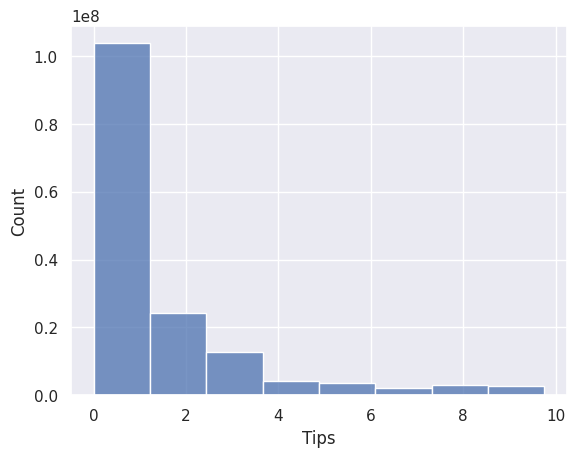

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy import stats
import shutil
def get_column___tips___from_pyspark(df_pyspark):
    #I need to save df[['Tips']] in a CSV file because the PySpark use many ram to convert a
    #dataframe to pandas
    df_tips=df[['Tips']].repartition(1).write.csv('data_to_plot_histogram.csv',header=True)
    files=os.listdir("data_to_plot_histogram.csv")
    file_csv=''
    for file in files:
        if(file[-3:]=='csv'):
            file_csv=file
            break
    
    df_dataframe=pd.read_csv("data_to_plot_histogram.csv/"+file_csv)
    shutil.rmtree("data_to_plot_histogram.csv")
    return df_dataframe
    
    
sns.set(style="darkgrid")
df_tips= get_column___tips___from_pyspark(df)
df_tips2=df_tips[(np.abs(stats.zscore(df_tips)) < 3)]# Remove outliers
sns.histplot(data=df_tips2, x="Tips",bins=8)
plt.show()

# Estudo do modelo de ML a ser utilizado e análise das variáveis

## Colher uma amostras dos dados para utilizar no Pycaret e Scikit



In [114]:
df_sample=df.sample(0.001,seed=20).toPandas()
df_sample

,Trip_ID,Trip_Miles,Trip_Seconds,Fare,Tips,Tolls,Extras,Trip_Total,trip_start_hour__00,trip_start_hour__01,...,payment_type__Credit_Card,payment_type__Dispute,payment_type__Mobile,payment_type__No_Charge,payment_type__Pcard,payment_type__Prcard,payment_type__Prepaid,payment_type__Split,payment_type__Unknown,payment_type__Way2ride
0,46e37b9ae5ddad70515f73084d1c4cb0f5340f1e,2.00,600.0,8.44,0.00,0.0,0.0,8.44,0,0,...,0,0,0,0,0,0,0,0,0,0
1,aaa9e44dd1e6c6bde5c774ecb6fb3394d39b339c,0.10,360.0,7.75,0.00,0.0,0.0,7.75,0,0,...,0,0,0,0,0,0,0,0,0,0
2,af0281869fb023de08e71d0bcf876b01b641cbbc,1.87,783.0,9.25,2.00,0.0,0.0,11.75,0,0,...,1,0,0,0,0,0,0,0,0,0
3,001ed4d077719aee50547373dabd6ace7859b52e,1.60,464.0,7.05,0.00,0.0,0.0,7.05,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1dacb683e4fb64a44d8acb29ad37c6f326fb3647,0.60,180.0,4.75,0.00,0.0,0.0,4.75,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161057,ff61befd76022832f22f70839347eca1db139a93,17.70,1416.0,43.75,9.55,0.0,4.0,57.30,0,0,...,1,0,0,0,0,0,0,0,0,0
161058,ff66db0feab4ef94843acdf64908ac132aa93f12,0.50,480.0,4.85,0.00,0.0,0.0,4.85,0,0,...,0,0,0,0,0,0,0,0,0,0
161059,ffa669605249ab2236ec1cde7181af998b516139,0.80,960.0,8.75,0.00,0.0,1.5,10.25,0,0,...,0,0,0,0,0,0,0,0,0,0
161060,ffc343a3f412894260393f3041d653e566810128,1.90,300.0,7.75,0.00,0.0,0.0,7.75,0,0,...,0,0,0,0,0,0,0,0,0,0


## Analisar pela amostra qual o melhor modelo de ML usando PyCaret

In [115]:
from pycaret.regression import *
df_sample_pycaret=df_sample.drop(['Trip_ID','Trip_Total'], axis=1).copy()
exp_reg101 = setup(data = df_sample_pycaret, target = 'Tips',normalize = True,silent=True) 
compare_models(exclude=['knn','gbr'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.4321,1.5734,1.2522,0.7853,0.2823,0.5852,0.3340
rf,Random Forest Regressor,0.4466,1.6403,1.2784,0.7762,0.2859,0.5952,19.6610
et,Extra Trees Regressor,0.4596,1.7005,1.3018,0.7680,0.2906,0.6177,30.9500
dt,Decision Tree Regressor,0.6183,3.0930,1.7564,0.5768,0.3925,0.7059,0.3250
ridge,Ridge Regression,0.9650,3.1097,1.7617,0.5743,0.4869,0.8375,0.0470
br,Bayesian Ridge,0.9644,3.1101,1.7618,0.5743,0.4865,0.8372,1.9470
omp,Orthogonal Matching Pursuit,0.9620,3.1200,1.7646,0.5729,0.4829,0.8376,0.1530
lr,Linear Regression,0.9658,3.1772,1.7797,0.5652,0.4872,0.8377,0.8320
huber,Huber Regressor,0.8094,3.6915,1.9189,0.4950,0.4341,0.6052,4.9850
en,Elastic Net,1.5593,5.9666,2.4417,0.1842,0.7261,0.6094,0.0640


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=7646, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

/home/kite/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: The outputs_2d_ attribute is deprecated in version 0.22 and will be removed in version 0.24. It is equivalent to n_outputs_ > 1.
  warnings.warn(msg, category=FutureWarning)
/home/kite/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: The outputs_2d_ attribute is deprecated in version 0.22 and will be removed in version 0.24. It is equivalent to n_outputs_ > 1.
  warnings.warn(msg, category=FutureWarning)
/home/kite/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: The outputs_2d_ attribute is deprecated in version 0.22 and will be removed in version 0.24. It is equivalent to n_outputs_ > 1.
  warnings.warn(msg, category=FutureWarning)
/home/kite/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: The outputs_2d_ attribute is deprecated in version 0.22 and will be removed in version 0.24. It is

Com base nos dados colhidos pelo PyCaret o **Light Gradient Boosting Machine**  é o melhor algoritmo de regressão para predição das gorjetas (**Tips**), contudo a versão mais próxima dele que existe no PySpark (o GBTRegressor) é custosa computacionalmente. Por essa razão vai ser utilizado um modelo do tipo **Random Forest**, que apresentou uma qualidade próxima do **Light Gradient Boosting Machine** .

Tanto o **Random Forest** quanto o **Light Gradient Boosting Machine** apresentaram boas métricas de qualidade, o que indica que modelos criados por esses algoritmos iriam funcionar bem na base de dados completa.

 # Transformações dos dados para o pacote de ML do Spark (MLlib)
 Dividir dados em teste e treino

In [5]:
df_train, df_test = df.randomSplit(weights=[0.8,0.2], seed=200)

# Coluna que vai ser predita pelo modelo

In [11]:
col_output=['Tips']
col_output[0]

'Tips'

 ## Colunas com dados continuos
 Nomes das colunas

In [12]:
cols_cont_atri=[    'Trip_Miles','Trip_Seconds',
                    'Fare','Tolls','Extras']
cols_cont_atri

['Trip_Miles', 'Trip_Seconds', 'Fare', 'Tolls', 'Extras']

 Criar um Vector Input para as colunas com dados continuos

In [8]:
vectorAssembler_input_continuos = VectorAssembler(
    inputCols=cols_cont_atri,
    outputCol="input_for_ml_continuous")
df_train = vectorAssembler_input_continuos.transform(df_train)
df_test = vectorAssembler_input_continuos.transform(df_test)

 Aplica a Standart scaler nas colunas *input_for_ml_continuous*

In [9]:
scaler_input = StandardScaler(inputCol="input_for_ml_continuous",
                              outputCol="input_for_ml_continuous_scaler",
                              withStd=True, withMean=True)
scaler_input_model = scaler_input.fit(df_train.sample(0.01))
df_train = scaler_input_model.transform(df_train)

df_test = scaler_input_model.transform(df_test)

23/01/12 17:16:35 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


##  Colunas com dados discretos

In [10]:
cols_disc_atri_temp=df.columns
cols_disc_atri=[]

for c in cols_disc_atri_temp:
    if not(c in (cols_cont_atri+col_output+['Trip_ID', 'Trip_Total'])):
        cols_disc_atri.append(c)
print(cols_disc_atri)

['trip_start_hour__00', 'trip_start_hour__01', 'trip_start_hour__02', 'trip_start_hour__03', 'trip_start_hour__04', 'trip_start_hour__05', 'trip_start_hour__06', 'trip_start_hour__07', 'trip_start_hour__08', 'trip_start_hour__09', 'trip_start_hour__10', 'trip_start_hour__11', 'trip_start_hour__12', 'trip_start_hour__13', 'trip_start_hour__14', 'trip_start_hour__15', 'trip_start_hour__16', 'trip_start_hour__17', 'trip_start_hour__18', 'trip_start_hour__19', 'trip_start_hour__20', 'trip_start_hour__21', 'trip_start_hour__22', 'trip_start_hour__23', 'trip_end_hour__00', 'trip_end_hour__01', 'trip_end_hour__02', 'trip_end_hour__03', 'trip_end_hour__04', 'trip_end_hour__05', 'trip_end_hour__06', 'trip_end_hour__07', 'trip_end_hour__08', 'trip_end_hour__09', 'trip_end_hour__10', 'trip_end_hour__11', 'trip_end_hour__12', 'trip_end_hour__13', 'trip_end_hour__14', 'trip_end_hour__15', 'trip_end_hour__16', 'trip_end_hour__17', 'trip_end_hour__18', 'trip_end_hour__19', 'trip_end_hour__20', 'trip_

 ## Juntar vetor da coluna *input_for_ml_continuous_scaler* com os valores das colunas com dados discretos. O novo vetor criado a partir dessa junção vai ser guardado na coluna *input_for_ml*.

In [11]:
vectorAssembler_input = VectorAssembler(
    inputCols=cols_disc_atri+['input_for_ml_continuous_scaler'],
    outputCol="input_for_ml")
df_train = vectorAssembler_input.transform(df_train)
df_test = vectorAssembler_input.transform(df_test)

  # Utilizar MLlib para criar modelo de machine learning

 Criar modelo de machine learning

In [12]:
'''
lr=LinearRegression(featuresCol='input_for_ml', labelCol='Tips',
                    regParam=0.3, elasticNetParam=0.8)
'''
rfg=RandomForestRegressor(numTrees=100,featuresCol='input_for_ml', labelCol='Tips')
model = rfg.fit(df_train)

23/01/12 17:30:22 WARN MemoryStore: Not enough space to cache rdd_33_4 in memory! (computed 230.3 MiB so far)
23/01/12 17:30:22 WARN BlockManager: Persisting block rdd_33_4 to disk instead.
23/01/12 17:30:22 WARN MemoryStore: Not enough space to cache rdd_33_9 in memory! (computed 230.3 MiB so far)
23/01/12 17:30:22 WARN BlockManager: Persisting block rdd_33_9 to disk instead.
23/01/12 17:30:22 WARN MemoryStore: Not enough space to cache rdd_33_3 in memory! (computed 230.3 MiB so far)
23/01/12 17:30:22 WARN BlockManager: Persisting block rdd_33_3 to disk instead.
23/01/12 17:30:25 WARN MemoryStore: Not enough space to cache rdd_33_10 in memory! (computed 348.4 MiB so far)
23/01/12 17:30:25 WARN BlockManager: Persisting block rdd_33_10 to disk instead.
23/01/12 17:30:25 WARN MemoryStore: Not enough space to cache rdd_33_6 in memory! (computed 348.4 MiB so far)
23/01/12 17:30:25 WARN BlockManager: Persisting block rdd_33_6 to disk instead.
23/01/12 17:30:25 WARN MemoryStore: Not enough s

23/01/12 17:30:59 WARN MemoryStore: Not enough space to cache rdd_33_8 in memory! (computed 152.6 MiB so far)
23/01/12 17:30:59 WARN MemoryStore: Not enough space to cache rdd_33_6 in memory! (computed 348.4 MiB so far)
23/01/12 17:30:59 WARN MemoryStore: Not enough space to cache rdd_33_1 in memory! (computed 348.4 MiB so far)
23/01/12 17:30:59 WARN MemoryStore: Not enough space to cache rdd_33_10 in memory! (computed 230.3 MiB so far)
23/01/12 17:30:59 WARN MemoryStore: Not enough space to cache rdd_33_3 in memory! (computed 152.6 MiB so far)
23/01/12 17:30:59 WARN MemoryStore: Not enough space to cache rdd_33_9 in memory! (computed 152.6 MiB so far)
23/01/12 17:30:59 WARN MemoryStore: Not enough space to cache rdd_33_4 in memory! (computed 101.7 MiB so far)
23/01/12 17:30:59 WARN MemoryStore: Not enough space to cache rdd_33_7 in memory! (computed 348.4 MiB so far)
23/01/12 17:30:59 WARN MemoryStore: Not enough space to cache rdd_33_11 in memory! (computed 540.8 MiB so far)


23/01/12 17:32:06 WARN MemoryStore: Not enough space to cache rdd_33_16 in memory! (computed 152.6 MiB so far)
23/01/12 17:32:06 WARN BlockManager: Persisting block rdd_33_16 to disk instead.
23/01/12 17:32:22 WARN MemoryStore: Not enough space to cache rdd_33_13 in memory! (computed 540.8 MiB so far)
23/01/12 17:32:22 WARN BlockManager: Persisting block rdd_33_13 to disk instead.
23/01/12 17:32:22 WARN MemoryStore: Not enough space to cache rdd_33_14 in memory! (computed 540.8 MiB so far)
23/01/12 17:32:22 WARN BlockManager: Persisting block rdd_33_14 to disk instead.
23/01/12 17:32:30 WARN MemoryStore: Not enough space to cache rdd_33_19 in memory! (computed 230.3 MiB so far)
23/01/12 17:32:30 WARN BlockManager: Persisting block rdd_33_19 to disk instead.
23/01/12 17:32:37 WARN MemoryStore: Not enough space to cache rdd_33_15 in memory! (computed 811.2 MiB so far)
23/01/12 17:32:37 WARN BlockManager: Persisting block rdd_33_15 to disk instead.
23/01/12 17:32:38 WARN MemoryStore: Not 

23/01/12 17:33:08 WARN MemoryStore: Not enough space to cache rdd_33_19 in memory! (computed 348.4 MiB so far)
23/01/12 17:33:09 WARN MemoryStore: Not enough space to cache rdd_33_20 in memory! (computed 152.6 MiB so far)
23/01/12 17:33:18 WARN MemoryStore: Not enough space to cache rdd_33_23 in memory! (computed 348.4 MiB so far)
23/01/12 17:33:18 WARN MemoryStore: Not enough space to cache rdd_33_21 in memory! (computed 811.2 MiB so far)


23/01/12 17:33:58 WARN MemoryStore: Not enough space to cache rdd_33_24 in memory! (computed 540.8 MiB so far)
23/01/12 17:33:58 WARN BlockManager: Persisting block rdd_33_24 to disk instead.


23/01/12 17:34:04 WARN MemoryStore: Not enough space to cache rdd_33_26 in memory! (computed 12.6 MiB so far)
23/01/12 17:34:04 WARN BlockManager: Persisting block rdd_33_26 to disk instead.


23/01/12 17:34:06 WARN MemoryStore: Not enough space to cache rdd_33_27 in memory! (computed 28.4 MiB so far)
23/01/12 17:34:06 WARN BlockManager: Persisting block rdd_33_27 to disk instead.
23/01/12 17:34:07 WARN MemoryStore: Not enough space to cache rdd_33_29 in memory! (computed 12.6 MiB so far)
23/01/12 17:34:07 WARN BlockManager: Persisting block rdd_33_29 to disk instead.
23/01/12 17:34:07 WARN MemoryStore: Not enough space to cache rdd_33_28 in memory! (computed 5.1 MiB so far)
23/01/12 17:34:07 WARN BlockManager: Persisting block rdd_33_28 to disk instead.
23/01/12 17:34:11 WARN MemoryStore: Not enough space to cache rdd_33_25 in memory! (computed 348.4 MiB so far)
23/01/12 17:34:11 WARN BlockManager: Persisting block rdd_33_25 to disk instead.
23/01/12 17:34:13 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_33_30 in memory.
23/01/12 17:34:13 WARN MemoryStore: Not enough space to cache rdd_33_30 in memory! (computed 384.0 B s

23/01/12 17:34:21 WARN MemoryStore: Not enough space to cache rdd_33_33 in memory! (computed 101.7 MiB so far)
23/01/12 17:34:21 WARN BlockManager: Persisting block rdd_33_33 to disk instead.
23/01/12 17:34:46 WARN MemoryStore: Not enough space to cache rdd_33_25 in memory! (computed 811.2 MiB so far)
23/01/12 17:34:46 WARN MemoryStore: Not enough space to cache rdd_33_34 in memory! (computed 230.3 MiB so far)
23/01/12 17:34:46 WARN BlockManager: Persisting block rdd_33_34 to disk instead.
23/01/12 17:34:47 WARN MemoryStore: Not enough space to cache rdd_33_26 in memory! (computed 540.8 MiB so far)
23/01/12 17:34:47 WARN MemoryStore: Not enough space to cache rdd_33_27 in memory! (computed 540.8 MiB so far)
23/01/12 17:34:49 WARN MemoryStore: Not enough space to cache rdd_33_29 in memory! (computed 348.4 MiB so far)
23/01/12 17:34:49 WARN MemoryStore: Not enough space to cache rdd_33_28 in memory! (computed 230.3 MiB so far)
23/01/12 17:34:52 WARN MemoryStore: Not enough space to cache

23/01/12 17:35:20 WARN MemoryStore: Not enough space to cache rdd_33_34 in memory! (computed 540.8 MiB so far)


23/01/12 17:35:59 WARN MemoryStore: Not enough space to cache rdd_33_37 in memory! (computed 230.3 MiB so far)
23/01/12 17:35:59 WARN BlockManager: Persisting block rdd_33_37 to disk instead.
23/01/12 17:36:00 WARN MemoryStore: Not enough space to cache rdd_33_38 in memory! (computed 230.3 MiB so far)
23/01/12 17:36:00 WARN BlockManager: Persisting block rdd_33_38 to disk instead.
23/01/12 17:36:04 WARN MemoryStore: Not enough space to cache rdd_33_39 in memory! (computed 3.4 MiB so far)
23/01/12 17:36:04 WARN BlockManager: Persisting block rdd_33_39 to disk instead.
23/01/12 17:36:04 WARN MemoryStore: Not enough space to cache rdd_33_42 in memory! (computed 12.6 MiB so far)
23/01/12 17:36:04 WARN BlockManager: Persisting block rdd_33_42 to disk instead.
23/01/12 17:36:04 WARN MemoryStore: Not enough space to cache rdd_33_44 in memory! (computed 1025.2 KiB so far)
23/01/12 17:36:04 WARN BlockManager: Persisting block rdd_33_44 to disk instead.
23/01/12 17:36:04 WARN MemoryStore: Not en

23/01/12 17:36:29 WARN MemoryStore: Not enough space to cache rdd_33_46 in memory! (computed 152.6 MiB so far)
23/01/12 17:36:29 WARN BlockManager: Persisting block rdd_33_46 to disk instead.
23/01/12 17:36:38 WARN MemoryStore: Not enough space to cache rdd_33_37 in memory! (computed 348.4 MiB so far)
23/01/12 17:36:39 WARN MemoryStore: Not enough space to cache rdd_33_38 in memory! (computed 348.4 MiB so far)
23/01/12 17:36:39 WARN MemoryStore: Not enough space to cache rdd_33_47 in memory! (computed 67.6 MiB so far)
23/01/12 17:36:39 WARN BlockManager: Persisting block rdd_33_47 to disk instead.
23/01/12 17:36:47 WARN MemoryStore: Not enough space to cache rdd_33_39 in memory! (computed 230.3 MiB so far)
23/01/12 17:36:47 WARN MemoryStore: Not enough space to cache rdd_33_41 in memory! (computed 540.8 MiB so far)
23/01/12 17:36:47 WARN MemoryStore: Not enough space to cache rdd_33_40 in memory! (computed 152.6 MiB so far)
23/01/12 17:36:47 WARN MemoryStore: Not enough space to cache 

23/01/12 17:37:55 WARN MemoryStore: Not enough space to cache rdd_33_49 in memory! (computed 152.6 MiB so far)
23/01/12 17:37:55 WARN BlockManager: Persisting block rdd_33_49 to disk instead.
23/01/12 17:37:59 WARN MemoryStore: Not enough space to cache rdd_33_50 in memory! (computed 12.6 MiB so far)
23/01/12 17:37:59 WARN BlockManager: Persisting block rdd_33_50 to disk instead.
23/01/12 17:38:07 WARN MemoryStore: Not enough space to cache rdd_33_51 in memory! (computed 230.3 MiB so far)
23/01/12 17:38:07 WARN BlockManager: Persisting block rdd_33_51 to disk instead.
23/01/12 17:38:07 WARN MemoryStore: Not enough space to cache rdd_33_55 in memory! (computed 101.7 MiB so far)
23/01/12 17:38:07 WARN BlockManager: Persisting block rdd_33_55 to disk instead.
23/01/12 17:38:07 WARN MemoryStore: Not enough space to cache rdd_33_56 in memory! (computed 28.4 MiB so far)
23/01/12 17:38:07 WARN BlockManager: Persisting block rdd_33_56 to disk instead.
23/01/12 17:38:07 WARN MemoryStore: Not en

23/01/12 17:38:17 WARN MemoryStore: Not enough space to cache rdd_33_54 in memory! (computed 540.8 MiB so far)
23/01/12 17:38:17 WARN BlockManager: Persisting block rdd_33_54 to disk instead.
23/01/12 17:38:32 WARN MemoryStore: Not enough space to cache rdd_33_58 in memory! (computed 540.8 MiB so far)
23/01/12 17:38:32 WARN BlockManager: Persisting block rdd_33_58 to disk instead.
23/01/12 17:38:33 WARN MemoryStore: Not enough space to cache rdd_33_49 in memory! (computed 152.6 MiB so far)
23/01/12 17:38:42 WARN MemoryStore: Not enough space to cache rdd_33_51 in memory! (computed 348.4 MiB so far)
23/01/12 17:38:43 WARN MemoryStore: Not enough space to cache rdd_33_50 in memory! (computed 540.8 MiB so far)
23/01/12 17:38:43 WARN MemoryStore: Not enough space to cache rdd_33_52 in memory! (computed 42.9 MiB so far)
23/01/12 17:38:44 WARN MemoryStore: Not enough space to cache rdd_33_59 in memory! (computed 811.2 MiB so far)
23/01/12 17:38:44 WARN BlockManager: Persisting block rdd_33_5

23/01/12 17:39:01 WARN MemoryStore: Not enough space to cache rdd_33_58 in memory! (computed 811.2 MiB so far)
23/01/12 17:39:01 WARN MemoryStore: Not enough space to cache rdd_33_59 in memory! (computed 230.3 MiB so far)
23/01/12 17:39:02 WARN MemoryStore: Not enough space to cache rdd_33_60 in memory! (computed 101.7 MiB so far)
23/01/12 17:39:02 WARN BlockManager: Persisting block rdd_33_60 to disk instead.


23/01/12 17:40:07 WARN MemoryStore: Not enough space to cache rdd_33_66 in memory! (computed 101.7 MiB so far)
23/01/12 17:40:07 WARN BlockManager: Persisting block rdd_33_66 to disk instead.
23/01/12 17:40:07 WARN MemoryStore: Not enough space to cache rdd_33_67 in memory! (computed 101.7 MiB so far)
23/01/12 17:40:07 WARN BlockManager: Persisting block rdd_33_67 to disk instead.
23/01/12 17:40:08 WARN MemoryStore: Not enough space to cache rdd_33_64 in memory! (computed 348.4 MiB so far)
23/01/12 17:40:08 WARN BlockManager: Persisting block rdd_33_64 to disk instead.
23/01/12 17:40:08 WARN MemoryStore: Not enough space to cache rdd_33_63 in memory! (computed 348.4 MiB so far)
23/01/12 17:40:08 WARN MemoryStore: Not enough space to cache rdd_33_62 in memory! (computed 348.4 MiB so far)
23/01/12 17:40:08 WARN BlockManager: Persisting block rdd_33_63 to disk instead.
23/01/12 17:40:08 WARN BlockManager: Persisting block rdd_33_62 to disk instead.
23/01/12 17:40:08 WARN MemoryStore: Not 

23/01/12 17:40:41 WARN MemoryStore: Not enough space to cache rdd_33_64 in memory! (computed 348.4 MiB so far)
23/01/12 17:40:42 WARN MemoryStore: Not enough space to cache rdd_33_62 in memory! (computed 348.4 MiB so far)
23/01/12 17:40:42 WARN MemoryStore: Not enough space to cache rdd_33_63 in memory! (computed 540.8 MiB so far)
23/01/12 17:40:45 WARN MemoryStore: Not enough space to cache rdd_33_67 in memory! (computed 19.0 MiB so far)
23/01/12 17:40:45 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_33_72 in memory.
23/01/12 17:40:45 WARN MemoryStore: Not enough space to cache rdd_33_72 in memory! (computed 384.0 B so far)
23/01/12 17:40:45 WARN BlockManager: Persisting block rdd_33_72 to disk instead.
23/01/12 17:40:45 WARN MemoryStore: Not enough space to cache rdd_33_69 in memory! (computed 152.6 MiB so far)
23/01/12 17:40:45 WARN MemoryStore: Not enough space to cache rdd_33_66 in memory! (computed 67.6 MiB so far)
23/01/12 17:

23/01/12 17:41:34 WARN MemoryStore: Not enough space to cache rdd_33_73 in memory! (computed 811.2 MiB so far)
23/01/12 17:41:34 WARN BlockManager: Persisting block rdd_33_73 to disk instead.


23/01/12 17:41:58 WARN MemoryStore: Not enough space to cache rdd_33_75 in memory! (computed 230.3 MiB so far)
23/01/12 17:41:58 WARN BlockManager: Persisting block rdd_33_75 to disk instead.
23/01/12 17:41:58 WARN MemoryStore: Not enough space to cache rdd_33_78 in memory! (computed 230.3 MiB so far)
23/01/12 17:41:58 WARN BlockManager: Persisting block rdd_33_78 to disk instead.
23/01/12 17:41:58 WARN MemoryStore: Not enough space to cache rdd_33_77 in memory! (computed 101.7 MiB so far)
23/01/12 17:41:58 WARN BlockManager: Persisting block rdd_33_77 to disk instead.
23/01/12 17:41:58 WARN MemoryStore: Not enough space to cache rdd_33_81 in memory! (computed 67.6 MiB so far)
23/01/12 17:41:58 WARN BlockManager: Persisting block rdd_33_81 to disk instead.
23/01/12 17:41:59 WARN MemoryStore: Not enough space to cache rdd_33_73 in memory! (computed 811.2 MiB so far)
23/01/12 17:42:02 WARN MemoryStore: Not enough space to cache rdd_33_80 in memory! (computed 230.3 MiB so far)
23/01/12 17

23/01/12 17:42:41 WARN MemoryStore: Not enough space to cache rdd_33_80 in memory! (computed 348.4 MiB so far)
23/01/12 17:42:42 WARN MemoryStore: Not enough space to cache rdd_33_77 in memory! (computed 348.4 MiB so far)
23/01/12 17:42:42 WARN MemoryStore: Not enough space to cache rdd_33_76 in memory! (computed 67.6 MiB so far)
23/01/12 17:42:42 WARN MemoryStore: Not enough space to cache rdd_33_81 in memory! (computed 348.4 MiB so far)
23/01/12 17:42:42 WARN MemoryStore: Not enough space to cache rdd_33_79 in memory! (computed 28.4 MiB so far)
23/01/12 17:42:42 WARN MemoryStore: Not enough space to cache rdd_33_78 in memory! (computed 811.2 MiB so far)
23/01/12 17:42:43 WARN MemoryStore: Not enough space to cache rdd_33_84 in memory! (computed 101.7 MiB so far)
23/01/12 17:42:43 WARN BlockManager: Persisting block rdd_33_84 to disk instead.
23/01/12 17:42:43 WARN MemoryStore: Not enough space to cache rdd_33_82 in memory! (computed 67.6 MiB so far)
23/01/12 17:42:47 WARN MemoryStore

23/01/12 17:43:54 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_33_89 in memory.
23/01/12 17:43:54 WARN MemoryStore: Not enough space to cache rdd_33_89 in memory! (computed 384.0 B so far)
23/01/12 17:43:54 WARN BlockManager: Persisting block rdd_33_89 to disk instead.
23/01/12 17:43:55 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_33_90 in memory.
23/01/12 17:43:55 WARN MemoryStore: Not enough space to cache rdd_33_90 in memory! (computed 384.0 B so far)
23/01/12 17:43:55 WARN BlockManager: Persisting block rdd_33_90 to disk instead.
23/01/12 17:43:56 WARN MemoryStore: Not enough space to cache rdd_33_88 in memory! (computed 28.4 MiB so far)
23/01/12 17:43:56 WARN BlockManager: Persisting block rdd_33_88 to disk instead.
23/01/12 17:43:56 WARN MemoryStore: Not enough space to cache rdd_33_91 in memory! (computed 19.0 MiB so far)
23/01/12 17:43:56 WARN BlockManager: Persisting blo

23/01/12 17:44:34 WARN MemoryStore: Not enough space to cache rdd_33_96 in memory! (computed 101.7 MiB so far)
23/01/12 17:44:34 WARN BlockManager: Persisting block rdd_33_96 to disk instead.
23/01/12 17:44:36 WARN MemoryStore: Not enough space to cache rdd_33_89 in memory! (computed 67.6 MiB so far)
23/01/12 17:44:38 WARN MemoryStore: Not enough space to cache rdd_33_88 in memory! (computed 101.7 MiB so far)
23/01/12 17:44:38 WARN MemoryStore: Not enough space to cache rdd_33_91 in memory! (computed 101.7 MiB so far)
23/01/12 17:44:39 WARN MemoryStore: Not enough space to cache rdd_33_90 in memory! (computed 152.6 MiB so far)
23/01/12 17:44:43 WARN MemoryStore: Not enough space to cache rdd_33_94 in memory! (computed 152.6 MiB so far)
23/01/12 17:44:53 WARN MemoryStore: Not enough space to cache rdd_33_95 in memory! (computed 540.8 MiB so far)
23/01/12 17:44:53 WARN MemoryStore: Not enough space to cache rdd_33_92 in memory! (computed 811.2 MiB so far)
23/01/12 17:44:53 WARN MemorySto

23/01/12 17:45:34 WARN MemoryStore: Not enough space to cache rdd_33_98 in memory! (computed 152.6 MiB so far)
23/01/12 17:45:34 WARN BlockManager: Persisting block rdd_33_98 to disk instead.


23/01/12 17:46:02 WARN MemoryStore: Not enough space to cache rdd_33_98 in memory! (computed 811.2 MiB so far)


23/01/12 17:46:31 WARN MemoryStore: Not enough space to cache rdd_33_2 in memory! (computed 67.6 MiB so far)
23/01/12 17:46:31 WARN MemoryStore: Not enough space to cache rdd_33_3 in memory! (computed 67.6 MiB so far)
23/01/12 17:46:32 WARN MemoryStore: Not enough space to cache rdd_33_4 in memory! (computed 101.7 MiB so far)
23/01/12 17:46:32 WARN MemoryStore: Not enough space to cache rdd_33_5 in memory! (computed 101.7 MiB so far)
23/01/12 17:46:32 WARN MemoryStore: Not enough space to cache rdd_33_7 in memory! (computed 101.7 MiB so far)
23/01/12 17:46:32 WARN MemoryStore: Not enough space to cache rdd_33_8 in memory! (computed 101.7 MiB so far)
23/01/12 17:46:32 WARN MemoryStore: Not enough space to cache rdd_33_11 in memory! (computed 101.7 MiB so far)
23/01/12 17:46:32 WARN MemoryStore: Not enough space to cache rdd_33_6 in memory! (computed 101.7 MiB so far)
23/01/12 17:46:32 WARN MemoryStore: Not enough space to cache rdd_33_1 in memory! (computed 101.7 MiB so far)
23/01/12 17

23/01/12 17:47:35 WARN MemoryStore: Not enough space to cache rdd_33_12 in memory! (computed 348.4 MiB so far)
23/01/12 17:47:36 WARN MemoryStore: Not enough space to cache rdd_33_15 in memory! (computed 152.6 MiB so far)
23/01/12 17:47:36 WARN MemoryStore: Not enough space to cache rdd_33_13 in memory! (computed 348.4 MiB so far)
23/01/12 17:47:36 WARN MemoryStore: Not enough space to cache rdd_33_16 in memory! (computed 67.6 MiB so far)


23/01/12 17:47:36 WARN MemoryStore: Not enough space to cache rdd_33_17 in memory! (computed 19.0 MiB so far)
23/01/12 17:47:36 WARN MemoryStore: Not enough space to cache rdd_33_14 in memory! (computed 230.3 MiB so far)
23/01/12 17:47:36 WARN MemoryStore: Not enough space to cache rdd_33_18 in memory! (computed 5.1 MiB so far)


23/01/12 17:47:37 WARN MemoryStore: Not enough space to cache rdd_33_19 in memory! (computed 8.4 MiB so far)


23/01/12 17:47:38 WARN MemoryStore: Not enough space to cache rdd_33_20 in memory! (computed 19.0 MiB so far)


23/01/12 17:47:38 WARN MemoryStore: Not enough space to cache rdd_33_21 in memory! (computed 8.4 MiB so far)


23/01/12 17:47:39 WARN MemoryStore: Not enough space to cache rdd_33_23 in memory! (computed 19.0 MiB so far)
23/01/12 17:47:39 WARN MemoryStore: Not enough space to cache rdd_33_22 in memory! (computed 67.6 MiB so far)


23/01/12 17:48:40 WARN MemoryStore: Not enough space to cache rdd_33_25 in memory! (computed 230.3 MiB so far)
23/01/12 17:48:40 WARN MemoryStore: Not enough space to cache rdd_33_28 in memory! (computed 101.7 MiB so far)
23/01/12 17:48:40 WARN MemoryStore: Not enough space to cache rdd_33_29 in memory! (computed 28.4 MiB so far)
23/01/12 17:48:40 WARN MemoryStore: Not enough space to cache rdd_33_26 in memory! (computed 230.3 MiB so far)


23/01/12 17:48:40 WARN MemoryStore: Not enough space to cache rdd_33_27 in memory! (computed 230.3 MiB so far)
23/01/12 17:48:40 WARN MemoryStore: Not enough space to cache rdd_33_30 in memory! (computed 1539.7 KiB so far)


23/01/12 17:48:40 WARN MemoryStore: Not enough space to cache rdd_33_24 in memory! (computed 348.4 MiB so far)
23/01/12 17:48:41 WARN MemoryStore: Not enough space to cache rdd_33_31 in memory! (computed 1539.7 KiB so far)


23/01/12 17:48:41 WARN MemoryStore: Not enough space to cache rdd_33_32 in memory! (computed 28.4 MiB so far)


23/01/12 17:48:43 WARN MemoryStore: Not enough space to cache rdd_33_33 in memory! (computed 28.4 MiB so far)
23/01/12 17:48:44 WARN MemoryStore: Not enough space to cache rdd_33_34 in memory! (computed 1539.7 KiB so far)


23/01/12 17:48:44 WARN MemoryStore: Not enough space to cache rdd_33_35 in memory! (computed 1539.7 KiB so far)


23/01/12 17:49:45 WARN MemoryStore: Not enough space to cache rdd_33_37 in memory! (computed 230.3 MiB so far)
23/01/12 17:49:45 WARN MemoryStore: Not enough space to cache rdd_33_38 in memory! (computed 152.6 MiB so far)
23/01/12 17:49:45 WARN MemoryStore: Not enough space to cache rdd_33_39 in memory! (computed 152.6 MiB so far)
23/01/12 17:49:45 WARN MemoryStore: Not enough space to cache rdd_33_41 in memory! (computed 101.7 MiB so far)
23/01/12 17:49:45 WARN MemoryStore: Not enough space to cache rdd_33_40 in memory! (computed 152.6 MiB so far)
23/01/12 17:49:45 WARN MemoryStore: Not enough space to cache rdd_33_36 in memory! (computed 348.4 MiB so far)
23/01/12 17:49:46 WARN MemoryStore: Not enough space to cache rdd_33_43 in memory! (computed 8.4 MiB so far)
23/01/12 17:49:46 WARN MemoryStore: Not enough space to cache rdd_33_42 in memory! (computed 19.0 MiB so far)


23/01/12 17:49:47 WARN MemoryStore: Not enough space to cache rdd_33_44 in memory! (computed 28.4 MiB so far)
23/01/12 17:49:47 WARN MemoryStore: Not enough space to cache rdd_33_45 in memory! (computed 1539.7 KiB so far)


23/01/12 17:49:51 WARN MemoryStore: Not enough space to cache rdd_33_46 in memory! (computed 67.6 MiB so far)
23/01/12 17:49:51 WARN MemoryStore: Not enough space to cache rdd_33_47 in memory! (computed 67.6 MiB so far)


23/01/12 17:50:49 WARN MemoryStore: Not enough space to cache rdd_33_48 in memory! (computed 540.8 MiB so far)


23/01/12 17:50:50 WARN MemoryStore: Not enough space to cache rdd_33_50 in memory! (computed 230.3 MiB so far)
23/01/12 17:50:50 WARN MemoryStore: Not enough space to cache rdd_33_51 in memory! (computed 67.6 MiB so far)


23/01/12 17:50:50 WARN MemoryStore: Not enough space to cache rdd_33_52 in memory! (computed 1539.7 KiB so far)
23/01/12 17:50:50 WARN MemoryStore: Not enough space to cache rdd_33_49 in memory! (computed 348.4 MiB so far)
23/01/12 17:50:50 WARN MemoryStore: Not enough space to cache rdd_33_53 in memory! (computed 1539.7 KiB so far)


23/01/12 17:50:51 WARN MemoryStore: Not enough space to cache rdd_33_54 in memory! (computed 1539.7 KiB so far)
23/01/12 17:50:51 WARN MemoryStore: Not enough space to cache rdd_33_55 in memory! (computed 1539.7 KiB so far)


23/01/12 17:50:51 WARN MemoryStore: Not enough space to cache rdd_33_56 in memory! (computed 1539.7 KiB so far)


23/01/12 17:50:54 WARN MemoryStore: Not enough space to cache rdd_33_57 in memory! (computed 67.6 MiB so far)
23/01/12 17:50:55 WARN MemoryStore: Not enough space to cache rdd_33_58 in memory! (computed 1539.7 KiB so far)


23/01/12 17:50:56 WARN MemoryStore: Not enough space to cache rdd_33_59 in memory! (computed 1539.7 KiB so far)


23/01/12 17:51:53 WARN MemoryStore: Not enough space to cache rdd_33_60 in memory! (computed 540.8 MiB so far)
23/01/12 17:51:54 WARN MemoryStore: Not enough space to cache rdd_33_62 in memory! (computed 230.3 MiB so far)


23/01/12 17:51:54 WARN MemoryStore: Not enough space to cache rdd_33_64 in memory! (computed 19.0 MiB so far)
23/01/12 17:51:54 WARN MemoryStore: Not enough space to cache rdd_33_63 in memory! (computed 42.9 MiB so far)
23/01/12 17:51:54 WARN MemoryStore: Not enough space to cache rdd_33_61 in memory! (computed 348.4 MiB so far)


23/01/12 17:51:54 WARN MemoryStore: Not enough space to cache rdd_33_65 in memory! (computed 3.4 MiB so far)
23/01/12 17:51:55 WARN MemoryStore: Not enough space to cache rdd_33_66 in memory! (computed 3.4 MiB so far)


23/01/12 17:51:56 WARN MemoryStore: Not enough space to cache rdd_33_67 in memory! (computed 19.0 MiB so far)
23/01/12 17:51:56 WARN MemoryStore: Not enough space to cache rdd_33_68 in memory! (computed 3.4 MiB so far)


23/01/12 17:52:00 WARN MemoryStore: Not enough space to cache rdd_33_69 in memory! (computed 67.6 MiB so far)
23/01/12 17:52:01 WARN MemoryStore: Not enough space to cache rdd_33_70 in memory! (computed 1539.7 KiB so far)


23/01/12 17:52:02 WARN MemoryStore: Not enough space to cache rdd_33_71 in memory! (computed 1539.7 KiB so far)


23/01/12 17:52:55 WARN MemoryStore: Not enough space to cache rdd_33_73 in memory! (computed 348.4 MiB so far)
23/01/12 17:52:55 WARN MemoryStore: Not enough space to cache rdd_33_75 in memory! (computed 101.7 MiB so far)
23/01/12 17:52:55 WARN MemoryStore: Not enough space to cache rdd_33_74 in memory! (computed 152.6 MiB so far)
23/01/12 17:52:55 WARN MemoryStore: Not enough space to cache rdd_33_72 in memory! (computed 540.8 MiB so far)


23/01/12 17:52:56 WARN MemoryStore: Not enough space to cache rdd_33_76 in memory! (computed 28.4 MiB so far)


23/01/12 17:52:57 WARN MemoryStore: Not enough space to cache rdd_33_77 in memory! (computed 12.6 MiB so far)
23/01/12 17:52:57 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_33_78 in memory.
23/01/12 17:52:57 WARN MemoryStore: Not enough space to cache rdd_33_78 in memory! (computed 384.0 B so far)


23/01/12 17:52:58 WARN MemoryStore: Not enough space to cache rdd_33_79 in memory! (computed 28.4 MiB so far)


23/01/12 17:53:01 WARN MemoryStore: Not enough space to cache rdd_33_80 in memory! (computed 101.7 MiB so far)


23/01/12 17:53:02 WARN MemoryStore: Not enough space to cache rdd_33_81 in memory! (computed 28.4 MiB so far)


23/01/12 17:53:05 WARN MemoryStore: Not enough space to cache rdd_33_82 in memory! (computed 101.7 MiB so far)
23/01/12 17:53:05 WARN MemoryStore: Not enough space to cache rdd_33_83 in memory! (computed 67.6 MiB so far)


23/01/12 17:54:00 WARN MemoryStore: Not enough space to cache rdd_33_85 in memory! (computed 348.4 MiB so far)
23/01/12 17:54:00 WARN MemoryStore: Not enough space to cache rdd_33_84 in memory! (computed 348.4 MiB so far)
23/01/12 17:54:00 WARN MemoryStore: Not enough space to cache rdd_33_86 in memory! (computed 230.3 MiB so far)
23/01/12 17:54:01 WARN MemoryStore: Not enough space to cache rdd_33_88 in memory! (computed 230.3 MiB so far)
23/01/12 17:54:03 WARN MemoryStore: Not enough space to cache rdd_33_89 in memory! (computed 12.6 MiB so far)
23/01/12 17:54:03 WARN MemoryStore: Not enough space to cache rdd_33_90 in memory! (computed 1539.7 KiB so far)


23/01/12 17:54:04 WARN MemoryStore: Not enough space to cache rdd_33_91 in memory! (computed 12.6 MiB so far)


23/01/12 17:54:06 WARN MemoryStore: Not enough space to cache rdd_33_92 in memory! (computed 12.6 MiB so far)


23/01/12 17:54:12 WARN MemoryStore: Not enough space to cache rdd_33_94 in memory! (computed 12.6 MiB so far)


23/01/12 17:54:15 WARN MemoryStore: Not enough space to cache rdd_33_95 in memory! (computed 348.4 MiB so far)


23/01/12 17:55:03 WARN MemoryStore: Not enough space to cache rdd_33_96 in memory! (computed 811.2 MiB so far)


23/01/12 17:55:07 WARN MemoryStore: Not enough space to cache rdd_33_98 in memory! (computed 348.4 MiB so far)


23/01/12 17:55:46 WARN MemoryStore: Not enough space to cache rdd_33_9 in memory! (computed 67.6 MiB so far)
23/01/12 17:55:46 WARN MemoryStore: Not enough space to cache rdd_33_0 in memory! (computed 67.6 MiB so far)
23/01/12 17:55:47 WARN MemoryStore: Not enough space to cache rdd_33_3 in memory! (computed 101.7 MiB so far)
23/01/12 17:55:47 WARN MemoryStore: Not enough space to cache rdd_33_7 in memory! (computed 101.7 MiB so far)
23/01/12 17:55:47 WARN MemoryStore: Not enough space to cache rdd_33_10 in memory! (computed 101.7 MiB so far)
23/01/12 17:55:47 WARN MemoryStore: Not enough space to cache rdd_33_6 in memory! (computed 101.7 MiB so far)
23/01/12 17:55:47 WARN MemoryStore: Not enough space to cache rdd_33_4 in memory! (computed 101.7 MiB so far)
23/01/12 17:55:47 WARN MemoryStore: Not enough space to cache rdd_33_11 in memory! (computed 101.7 MiB so far)
23/01/12 17:55:47 WARN MemoryStore: Not enough space to cache rdd_33_2 in memory! (computed 101.7 MiB so far)
23/01/12 1

23/01/12 17:56:57 WARN MemoryStore: Not enough space to cache rdd_33_14 in memory! (computed 152.6 MiB so far)
23/01/12 17:56:57 WARN MemoryStore: Not enough space to cache rdd_33_19 in memory! (computed 42.9 MiB so far)
23/01/12 17:56:58 WARN MemoryStore: Not enough space to cache rdd_33_20 in memory! (computed 19.0 MiB so far)
23/01/12 17:56:58 WARN MemoryStore: Not enough space to cache rdd_33_18 in memory! (computed 67.6 MiB so far)
23/01/12 17:56:58 WARN MemoryStore: Not enough space to cache rdd_33_17 in memory! (computed 101.7 MiB so far)
23/01/12 17:56:58 WARN MemoryStore: Not enough space to cache rdd_33_21 in memory! (computed 19.0 MiB so far)
23/01/12 17:56:58 WARN MemoryStore: Not enough space to cache rdd_33_15 in memory! (computed 152.6 MiB so far)
23/01/12 17:56:58 WARN MemoryStore: Not enough space to cache rdd_33_12 in memory! (computed 230.3 MiB so far)
23/01/12 17:56:58 WARN MemoryStore: Not enough space to cache rdd_33_16 in memory! (computed 152.6 MiB so far)
23/01

23/01/12 17:57:00 WARN MemoryStore: Not enough space to cache rdd_33_23 in memory! (computed 28.4 MiB so far)


23/01/12 17:58:12 WARN MemoryStore: Not enough space to cache rdd_33_25 in memory! (computed 348.4 MiB so far)
23/01/12 17:58:12 WARN MemoryStore: Not enough space to cache rdd_33_26 in memory! (computed 230.3 MiB so far)
23/01/12 17:58:12 WARN MemoryStore: Not enough space to cache rdd_33_24 in memory! (computed 540.8 MiB so far)


23/01/12 17:58:13 WARN MemoryStore: Not enough space to cache rdd_33_27 in memory! (computed 67.6 MiB so far)
23/01/12 17:58:14 WARN MemoryStore: Not enough space to cache rdd_33_28 in memory! (computed 1539.7 KiB so far)


23/01/12 17:58:14 WARN MemoryStore: Not enough space to cache rdd_33_29 in memory! (computed 1539.7 KiB so far)
23/01/12 17:58:14 WARN MemoryStore: Not enough space to cache rdd_33_30 in memory! (computed 1539.7 KiB so far)


23/01/12 17:58:14 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_33_31 in memory.
23/01/12 17:58:14 WARN MemoryStore: Not enough space to cache rdd_33_31 in memory! (computed 384.0 B so far)
23/01/12 17:58:15 WARN MemoryStore: Not enough space to cache rdd_33_32 in memory! (computed 1539.7 KiB so far)


23/01/12 17:58:16 WARN MemoryStore: Not enough space to cache rdd_33_33 in memory! (computed 1539.7 KiB so far)
23/01/12 17:58:16 WARN MemoryStore: Not enough space to cache rdd_33_34 in memory! (computed 1539.7 KiB so far)


23/01/12 17:58:18 WARN MemoryStore: Not enough space to cache rdd_33_35 in memory! (computed 67.6 MiB so far)


23/01/12 17:59:19 WARN MemoryStore: Not enough space to cache rdd_33_36 in memory! (computed 540.8 MiB so far)
23/01/12 17:59:20 WARN MemoryStore: Not enough space to cache rdd_33_37 in memory! (computed 540.8 MiB so far)


23/01/12 17:59:21 WARN MemoryStore: Not enough space to cache rdd_33_39 in memory! (computed 12.6 MiB so far)
23/01/12 17:59:21 WARN MemoryStore: Not enough space to cache rdd_33_38 in memory! (computed 101.7 MiB so far)
23/01/12 17:59:22 WARN MemoryStore: Not enough space to cache rdd_33_41 in memory! (computed 5.1 MiB so far)
23/01/12 17:59:22 WARN MemoryStore: Not enough space to cache rdd_33_42 in memory! (computed 3.4 MiB so far)
23/01/12 17:59:22 WARN MemoryStore: Not enough space to cache rdd_33_40 in memory! (computed 8.4 MiB so far)


23/01/12 17:59:23 WARN MemoryStore: Not enough space to cache rdd_33_43 in memory! (computed 12.6 MiB so far)
23/01/12 17:59:24 WARN MemoryStore: Not enough space to cache rdd_33_44 in memory! (computed 12.6 MiB so far)
23/01/12 17:59:24 WARN MemoryStore: Not enough space to cache rdd_33_45 in memory! (computed 3.4 MiB so far)


23/01/12 17:59:24 WARN MemoryStore: Not enough space to cache rdd_33_46 in memory! (computed 3.4 MiB so far)


23/01/12 17:59:26 WARN MemoryStore: Not enough space to cache rdd_33_47 in memory! (computed 101.7 MiB so far)


23/01/12 18:00:29 WARN MemoryStore: Not enough space to cache rdd_33_51 in memory! (computed 67.6 MiB so far)
23/01/12 18:00:29 WARN MemoryStore: Not enough space to cache rdd_33_50 in memory! (computed 230.3 MiB so far)
23/01/12 18:00:29 WARN MemoryStore: Not enough space to cache rdd_33_48 in memory! (computed 540.8 MiB so far)
23/01/12 18:00:29 WARN MemoryStore: Not enough space to cache rdd_33_52 in memory! (computed 1539.7 KiB so far)


23/01/12 18:00:29 WARN MemoryStore: Not enough space to cache rdd_33_49 in memory! (computed 348.4 MiB so far)
23/01/12 18:00:30 WARN MemoryStore: Not enough space to cache rdd_33_53 in memory! (computed 1539.7 KiB so far)


23/01/12 18:00:31 WARN MemoryStore: Not enough space to cache rdd_33_54 in memory! (computed 1539.7 KiB so far)
23/01/12 18:00:32 WARN MemoryStore: Not enough space to cache rdd_33_55 in memory! (computed 1539.7 KiB so far)


23/01/12 18:00:33 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_33_57 in memory.
23/01/12 18:00:33 WARN MemoryStore: Not enough space to cache rdd_33_57 in memory! (computed 384.0 B so far)
23/01/12 18:00:33 WARN MemoryStore: Not enough space to cache rdd_33_56 in memory! (computed 1539.7 KiB so far)


23/01/12 18:00:33 WARN MemoryStore: Not enough space to cache rdd_33_58 in memory! (computed 67.6 MiB so far)
23/01/12 18:00:34 WARN MemoryStore: Not enough space to cache rdd_33_59 in memory! (computed 1539.7 KiB so far)


23/01/12 18:01:36 WARN MemoryStore: Not enough space to cache rdd_33_62 in memory! (computed 5.1 MiB so far)
23/01/12 18:01:36 WARN MemoryStore: Not enough space to cache rdd_33_61 in memory! (computed 348.4 MiB so far)
23/01/12 18:01:36 WARN MemoryStore: Not enough space to cache rdd_33_60 in memory! (computed 811.2 MiB so far)
23/01/12 18:01:36 WARN MemoryStore: Not enough space to cache rdd_33_63 in memory! (computed 1539.7 KiB so far)


23/01/12 18:01:37 WARN MemoryStore: Not enough space to cache rdd_33_64 in memory! (computed 5.1 MiB so far)
23/01/12 18:01:37 WARN MemoryStore: Not enough space to cache rdd_33_65 in memory! (computed 1539.7 KiB so far)
23/01/12 18:01:39 WARN MemoryStore: Not enough space to cache rdd_33_66 in memory! (computed 5.1 MiB so far)


23/01/12 18:01:39 WARN MemoryStore: Not enough space to cache rdd_33_67 in memory! (computed 5.1 MiB so far)


23/01/12 18:01:40 WARN MemoryStore: Not enough space to cache rdd_33_68 in memory! (computed 5.1 MiB so far)
23/01/12 18:01:40 WARN MemoryStore: Not enough space to cache rdd_33_69 in memory! (computed 1539.7 KiB so far)


23/01/12 18:01:42 WARN MemoryStore: Not enough space to cache rdd_33_70 in memory! (computed 5.1 MiB so far)


23/01/12 18:01:42 WARN MemoryStore: Not enough space to cache rdd_33_71 in memory! (computed 5.1 MiB so far)


23/01/12 18:02:43 WARN MemoryStore: Not enough space to cache rdd_33_74 in memory! (computed 5.1 MiB so far)
23/01/12 18:02:44 WARN MemoryStore: Not enough space to cache rdd_33_73 in memory! (computed 348.4 MiB so far)
23/01/12 18:02:44 WARN MemoryStore: Not enough space to cache rdd_33_75 in memory! (computed 5.1 MiB so far)


23/01/12 18:02:44 WARN MemoryStore: Not enough space to cache rdd_33_72 in memory! (computed 811.2 MiB so far)
23/01/12 18:02:44 WARN MemoryStore: Not enough space to cache rdd_33_76 in memory! (computed 5.1 MiB so far)


23/01/12 18:02:46 WARN MemoryStore: Not enough space to cache rdd_33_77 in memory! (computed 5.1 MiB so far)
23/01/12 18:02:46 WARN MemoryStore: Not enough space to cache rdd_33_78 in memory! (computed 1539.7 KiB so far)


23/01/12 18:02:48 WARN MemoryStore: Not enough space to cache rdd_33_79 in memory! (computed 5.1 MiB so far)
23/01/12 18:02:49 WARN MemoryStore: Not enough space to cache rdd_33_80 in memory! (computed 5.1 MiB so far)


23/01/12 18:02:49 WARN MemoryStore: Not enough space to cache rdd_33_81 in memory! (computed 5.1 MiB so far)


23/01/12 18:02:50 WARN MemoryStore: Not enough space to cache rdd_33_82 in memory! (computed 5.1 MiB so far)
23/01/12 18:02:51 WARN MemoryStore: Not enough space to cache rdd_33_83 in memory! (computed 5.1 MiB so far)


23/01/12 18:03:51 WARN MemoryStore: Not enough space to cache rdd_33_85 in memory! (computed 348.4 MiB so far)
23/01/12 18:03:51 WARN MemoryStore: Not enough space to cache rdd_33_84 in memory! (computed 811.2 MiB so far)


23/01/12 18:03:53 WARN MemoryStore: Not enough space to cache rdd_33_86 in memory! (computed 5.1 MiB so far)


23/01/12 18:03:55 WARN MemoryStore: Not enough space to cache rdd_33_88 in memory! (computed 5.1 MiB so far)


23/01/12 18:03:55 WARN MemoryStore: Not enough space to cache rdd_33_89 in memory! (computed 5.1 MiB so far)


23/01/12 18:03:58 WARN MemoryStore: Not enough space to cache rdd_33_90 in memory! (computed 5.1 MiB so far)
23/01/12 18:03:58 WARN MemoryStore: Not enough space to cache rdd_33_91 in memory! (computed 1539.7 KiB so far)


23/01/12 18:04:00 WARN MemoryStore: Not enough space to cache rdd_33_92 in memory! (computed 5.1 MiB so far)


23/01/12 18:04:01 WARN MemoryStore: Not enough space to cache rdd_33_94 in memory! (computed 5.1 MiB so far)
23/01/12 18:04:02 WARN MemoryStore: Not enough space to cache rdd_33_95 in memory! (computed 5.1 MiB so far)


23/01/12 18:04:56 WARN MemoryStore: Not enough space to cache rdd_33_98 in memory! (computed 348.4 MiB so far)
23/01/12 18:04:57 WARN MemoryStore: Not enough space to cache rdd_33_96 in memory! (computed 811.2 MiB so far)


23/01/12 18:05:40 WARN MemoryStore: Not enough space to cache rdd_33_6 in memory! (computed 67.6 MiB so far)
23/01/12 18:05:40 WARN MemoryStore: Not enough space to cache rdd_33_0 in memory! (computed 67.6 MiB so far)
23/01/12 18:05:40 WARN MemoryStore: Not enough space to cache rdd_33_1 in memory! (computed 101.7 MiB so far)
23/01/12 18:05:40 WARN MemoryStore: Not enough space to cache rdd_33_9 in memory! (computed 101.7 MiB so far)
23/01/12 18:05:40 WARN MemoryStore: Not enough space to cache rdd_33_5 in memory! (computed 101.7 MiB so far)
23/01/12 18:05:40 WARN MemoryStore: Not enough space to cache rdd_33_3 in memory! (computed 101.7 MiB so far)
23/01/12 18:05:40 WARN MemoryStore: Not enough space to cache rdd_33_11 in memory! (computed 101.7 MiB so far)
23/01/12 18:05:40 WARN MemoryStore: Not enough space to cache rdd_33_8 in memory! (computed 101.7 MiB so far)
23/01/12 18:05:40 WARN MemoryStore: Not enough space to cache rdd_33_10 in memory! (computed 101.7 MiB so far)
23/01/12 1

23/01/12 18:07:05 WARN MemoryStore: Not enough space to cache rdd_33_16 in memory! (computed 67.6 MiB so far)
23/01/12 18:07:05 WARN MemoryStore: Not enough space to cache rdd_33_17 in memory! (computed 67.6 MiB so far)
23/01/12 18:07:05 WARN MemoryStore: Not enough space to cache rdd_33_18 in memory! (computed 12.6 MiB so far)
23/01/12 18:07:05 WARN MemoryStore: Not enough space to cache rdd_33_12 in memory! (computed 348.4 MiB so far)
23/01/12 18:07:05 WARN MemoryStore: Not enough space to cache rdd_33_14 in memory! (computed 230.3 MiB so far)
23/01/12 18:07:05 WARN MemoryStore: Not enough space to cache rdd_33_15 in memory! (computed 101.7 MiB so far)
23/01/12 18:07:05 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_33_19 in memory.
23/01/12 18:07:05 WARN MemoryStore: Not enough space to cache rdd_33_19 in memory! (computed 384.0 B so far)


23/01/12 18:07:05 WARN MemoryStore: Not enough space to cache rdd_33_13 in memory! (computed 348.4 MiB so far)
23/01/12 18:07:05 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_33_20 in memory.
23/01/12 18:07:05 WARN MemoryStore: Not enough space to cache rdd_33_20 in memory! (computed 384.0 B so far)


23/01/12 18:07:06 WARN MemoryStore: Not enough space to cache rdd_33_21 in memory! (computed 8.4 MiB so far)
23/01/12 18:07:06 WARN MemoryStore: Not enough space to cache rdd_33_22 in memory! (computed 5.1 MiB so far)


23/01/12 18:07:07 WARN MemoryStore: Not enough space to cache rdd_33_23 in memory! (computed 12.6 MiB so far)


23/01/12 18:08:32 WARN MemoryStore: Not enough space to cache rdd_33_25 in memory! (computed 152.6 MiB so far)
23/01/12 18:08:32 WARN MemoryStore: Not enough space to cache rdd_33_26 in memory! (computed 152.6 MiB so far)
23/01/12 18:08:32 WARN MemoryStore: Not enough space to cache rdd_33_29 in memory! (computed 28.4 MiB so far)
23/01/12 18:08:32 WARN MemoryStore: Not enough space to cache rdd_33_30 in memory! (computed 1025.2 KiB so far)
23/01/12 18:08:32 WARN MemoryStore: Not enough space to cache rdd_33_31 in memory! (computed 1025.2 KiB so far)


23/01/12 18:08:32 WARN MemoryStore: Not enough space to cache rdd_33_27 in memory! (computed 152.6 MiB so far)
23/01/12 18:08:32 WARN MemoryStore: Not enough space to cache rdd_33_28 in memory! (computed 152.6 MiB so far)
23/01/12 18:08:32 WARN MemoryStore: Not enough space to cache rdd_33_24 in memory! (computed 540.8 MiB so far)
23/01/12 18:08:32 WARN MemoryStore: Not enough space to cache rdd_33_32 in memory! (computed 1539.7 KiB so far)
23/01/12 18:08:33 WARN MemoryStore: Not enough space to cache rdd_33_33 in memory! (computed 1539.7 KiB so far)
23/01/12 18:08:33 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_33_34 in memory.
23/01/12 18:08:33 WARN MemoryStore: Not enough space to cache rdd_33_34 in memory! (computed 384.0 B so far)


23/01/12 18:08:34 WARN MemoryStore: Not enough space to cache rdd_33_35 in memory! (computed 1539.7 KiB so far)


23/01/12 18:09:55 WARN MemoryStore: Not enough space to cache rdd_33_41 in memory! (computed 5.1 MiB so far)


23/01/12 18:09:56 WARN MemoryStore: Not enough space to cache rdd_33_40 in memory! (computed 101.7 MiB so far)
23/01/12 18:09:56 WARN MemoryStore: Not enough space to cache rdd_33_39 in memory! (computed 152.6 MiB so far)
23/01/12 18:09:56 WARN MemoryStore: Not enough space to cache rdd_33_37 in memory! (computed 230.3 MiB so far)
23/01/12 18:09:56 WARN MemoryStore: Not enough space to cache rdd_33_38 in memory! (computed 152.6 MiB so far)
23/01/12 18:09:56 WARN MemoryStore: Not enough space to cache rdd_33_36 in memory! (computed 540.8 MiB so far)
23/01/12 18:09:57 WARN MemoryStore: Not enough space to cache rdd_33_43 in memory! (computed 1539.7 KiB so far)
23/01/12 18:09:57 WARN MemoryStore: Not enough space to cache rdd_33_42 in memory! (computed 3.4 MiB so far)


23/01/12 18:09:57 WARN MemoryStore: Not enough space to cache rdd_33_44 in memory! (computed 3.4 MiB so far)
23/01/12 18:09:58 WARN MemoryStore: Not enough space to cache rdd_33_45 in memory! (computed 1539.7 KiB so far)


23/01/12 18:09:58 WARN MemoryStore: Not enough space to cache rdd_33_46 in memory! (computed 5.1 MiB so far)


23/01/12 18:10:00 WARN MemoryStore: Not enough space to cache rdd_33_47 in memory! (computed 5.1 MiB so far)


23/01/12 18:11:19 WARN MemoryStore: Not enough space to cache rdd_33_49 in memory! (computed 230.3 MiB so far)
23/01/12 18:11:19 WARN MemoryStore: Not enough space to cache rdd_33_48 in memory! (computed 811.2 MiB so far)
23/01/12 18:11:19 WARN MemoryStore: Not enough space to cache rdd_33_50 in memory! (computed 101.7 MiB so far)


23/01/12 18:11:20 WARN MemoryStore: Not enough space to cache rdd_33_51 in memory! (computed 19.0 MiB so far)
23/01/12 18:11:20 WARN MemoryStore: Not enough space to cache rdd_33_52 in memory! (computed 2.3 MiB so far)


23/01/12 18:11:21 WARN MemoryStore: Not enough space to cache rdd_33_53 in memory! (computed 2.3 MiB so far)
23/01/12 18:11:21 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_33_54 in memory.
23/01/12 18:11:21 WARN MemoryStore: Not enough space to cache rdd_33_54 in memory! (computed 384.0 B so far)
23/01/12 18:11:21 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_33_55 in memory.
23/01/12 18:11:21 WARN MemoryStore: Not enough space to cache rdd_33_55 in memory! (computed 384.0 B so far)


23/01/12 18:11:21 WARN MemoryStore: Not enough space to cache rdd_33_56 in memory! (computed 2.3 MiB so far)


23/01/12 18:11:23 WARN MemoryStore: Not enough space to cache rdd_33_57 in memory! (computed 19.0 MiB so far)


23/01/12 18:11:25 WARN MemoryStore: Not enough space to cache rdd_33_58 in memory! (computed 19.0 MiB so far)


23/01/12 18:11:27 WARN MemoryStore: Not enough space to cache rdd_33_59 in memory! (computed 101.7 MiB so far)


23/01/12 18:12:43 WARN MemoryStore: Not enough space to cache rdd_33_62 in memory! (computed 42.9 MiB so far)
23/01/12 18:12:44 WARN MemoryStore: Not enough space to cache rdd_33_63 in memory! (computed 42.9 MiB so far)
23/01/12 18:12:44 WARN MemoryStore: Not enough space to cache rdd_33_64 in memory! (computed 28.4 MiB so far)
23/01/12 18:12:44 WARN MemoryStore: Not enough space to cache rdd_33_61 in memory! (computed 230.3 MiB so far)
23/01/12 18:12:44 WARN MemoryStore: Not enough space to cache rdd_33_65 in memory! (computed 5.1 MiB so far)
23/01/12 18:12:44 WARN MemoryStore: Not enough space to cache rdd_33_66 in memory! (computed 3.4 MiB so far)


23/01/12 18:12:45 WARN MemoryStore: Not enough space to cache rdd_33_60 in memory! (computed 811.2 MiB so far)
23/01/12 18:12:45 WARN MemoryStore: Not enough space to cache rdd_33_67 in memory! (computed 8.4 MiB so far)


23/01/12 18:12:45 WARN MemoryStore: Not enough space to cache rdd_33_68 in memory! (computed 8.4 MiB so far)


23/01/12 18:12:46 WARN MemoryStore: Not enough space to cache rdd_33_69 in memory! (computed 28.4 MiB so far)


23/01/12 18:12:51 WARN MemoryStore: Not enough space to cache rdd_33_70 in memory! (computed 101.7 MiB so far)
23/01/12 18:12:51 WARN MemoryStore: Not enough space to cache rdd_33_71 in memory! (computed 19.0 MiB so far)


23/01/12 18:14:11 WARN MemoryStore: Not enough space to cache rdd_33_75 in memory! (computed 101.7 MiB so far)
23/01/12 18:14:12 WARN MemoryStore: Not enough space to cache rdd_33_76 in memory! (computed 28.4 MiB so far)


23/01/12 18:14:12 WARN MemoryStore: Not enough space to cache rdd_33_73 in memory! (computed 348.4 MiB so far)
23/01/12 18:14:12 WARN MemoryStore: Not enough space to cache rdd_33_74 in memory! (computed 152.6 MiB so far)


23/01/12 18:14:12 WARN MemoryStore: Not enough space to cache rdd_33_77 in memory! (computed 12.6 MiB so far)
23/01/12 18:14:12 WARN MemoryStore: Not enough space to cache rdd_33_72 in memory! (computed 540.8 MiB so far)
23/01/12 18:14:14 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_33_78 in memory.
23/01/12 18:14:14 WARN MemoryStore: Not enough space to cache rdd_33_78 in memory! (computed 384.0 B so far)


23/01/12 18:14:15 WARN MemoryStore: Not enough space to cache rdd_33_79 in memory! (computed 28.4 MiB so far)


23/01/12 18:14:16 WARN MemoryStore: Not enough space to cache rdd_33_80 in memory! (computed 8.4 MiB so far)
23/01/12 18:14:16 WARN MemoryStore: Not enough space to cache rdd_33_81 in memory! (computed 5.1 MiB so far)


23/01/12 18:14:17 WARN MemoryStore: Not enough space to cache rdd_33_82 in memory! (computed 28.4 MiB so far)


23/01/12 18:14:19 WARN MemoryStore: Not enough space to cache rdd_33_83 in memory! (computed 101.7 MiB so far)


23/01/12 18:15:40 WARN MemoryStore: Not enough space to cache rdd_33_86 in memory! (computed 101.7 MiB so far)
23/01/12 18:15:40 WARN MemoryStore: Not enough space to cache rdd_33_84 in memory! (computed 540.8 MiB so far)


23/01/12 18:15:40 WARN MemoryStore: Not enough space to cache rdd_33_88 in memory! (computed 12.6 MiB so far)
23/01/12 18:15:41 WARN MemoryStore: Not enough space to cache rdd_33_85 in memory! (computed 540.8 MiB so far)
23/01/12 18:15:41 WARN MemoryStore: Not enough space to cache rdd_33_89 in memory! (computed 3.4 MiB so far)


23/01/12 18:15:42 WARN MemoryStore: Not enough space to cache rdd_33_90 in memory! (computed 12.6 MiB so far)


23/01/12 18:15:42 WARN MemoryStore: Not enough space to cache rdd_33_91 in memory! (computed 3.4 MiB so far)


23/01/12 18:15:43 WARN MemoryStore: Not enough space to cache rdd_33_92 in memory! (computed 12.6 MiB so far)


23/01/12 18:15:46 WARN MemoryStore: Not enough space to cache rdd_33_94 in memory! (computed 12.6 MiB so far)


23/01/12 18:15:49 WARN MemoryStore: Not enough space to cache rdd_33_95 in memory! (computed 101.7 MiB so far)


23/01/12 18:17:00 WARN MemoryStore: Not enough space to cache rdd_33_96 in memory! (computed 811.2 MiB so far)


23/01/12 18:17:05 WARN MemoryStore: Not enough space to cache rdd_33_98 in memory! (computed 348.4 MiB so far)


23/01/12 18:17:51 WARN MemoryStore: Not enough space to cache rdd_33_8 in memory! (computed 67.6 MiB so far)
23/01/12 18:17:51 WARN MemoryStore: Not enough space to cache rdd_33_7 in memory! (computed 67.6 MiB so far)
23/01/12 18:17:51 WARN MemoryStore: Not enough space to cache rdd_33_4 in memory! (computed 101.7 MiB so far)
23/01/12 18:17:51 WARN MemoryStore: Not enough space to cache rdd_33_2 in memory! (computed 101.7 MiB so far)
23/01/12 18:17:51 WARN MemoryStore: Not enough space to cache rdd_33_1 in memory! (computed 101.7 MiB so far)
23/01/12 18:17:51 WARN MemoryStore: Not enough space to cache rdd_33_10 in memory! (computed 101.7 MiB so far)
23/01/12 18:17:51 WARN MemoryStore: Not enough space to cache rdd_33_6 in memory! (computed 101.7 MiB so far)
23/01/12 18:17:51 WARN MemoryStore: Not enough space to cache rdd_33_5 in memory! (computed 101.7 MiB so far)
23/01/12 18:17:51 WARN MemoryStore: Not enough space to cache rdd_33_3 in memory! (computed 101.7 MiB so far)
23/01/12 18

23/01/12 18:19:47 WARN MemoryStore: Not enough space to cache rdd_33_17 in memory! (computed 42.9 MiB so far)
23/01/12 18:19:47 WARN MemoryStore: Not enough space to cache rdd_33_13 in memory! (computed 230.3 MiB so far)
23/01/12 18:19:47 WARN MemoryStore: Not enough space to cache rdd_33_16 in memory! (computed 101.7 MiB so far)
23/01/12 18:19:47 WARN MemoryStore: Not enough space to cache rdd_33_18 in memory! (computed 42.9 MiB so far)
23/01/12 18:19:47 WARN MemoryStore: Not enough space to cache rdd_33_12 in memory! (computed 348.4 MiB so far)


23/01/12 18:19:47 WARN MemoryStore: Not enough space to cache rdd_33_14 in memory! (computed 230.3 MiB so far)
23/01/12 18:19:47 WARN MemoryStore: Not enough space to cache rdd_33_15 in memory! (computed 152.6 MiB so far)
23/01/12 18:19:47 WARN MemoryStore: Not enough space to cache rdd_33_19 in memory! (computed 19.0 MiB so far)


23/01/12 18:19:50 WARN MemoryStore: Not enough space to cache rdd_33_21 in memory! (computed 348.4 MiB so far)
23/01/12 18:19:50 WARN MemoryStore: Not enough space to cache rdd_33_22 in memory! (computed 348.4 MiB so far)
23/01/12 18:19:51 WARN MemoryStore: Not enough space to cache rdd_33_20 in memory! (computed 540.8 MiB so far)


23/01/12 18:19:53 WARN MemoryStore: Not enough space to cache rdd_33_23 in memory! (computed 67.6 MiB so far)


23/01/12 18:21:44 WARN MemoryStore: Not enough space to cache rdd_33_24 in memory! (computed 811.2 MiB so far)
23/01/12 18:21:45 WARN MemoryStore: Not enough space to cache rdd_33_26 in memory! (computed 540.8 MiB so far)


23/01/12 18:21:46 WARN MemoryStore: Not enough space to cache rdd_33_25 in memory! (computed 811.2 MiB so far)
23/01/12 18:21:47 WARN MemoryStore: Not enough space to cache rdd_33_27 in memory! (computed 152.6 MiB so far)


23/01/12 18:21:47 WARN MemoryStore: Not enough space to cache rdd_33_28 in memory! (computed 67.6 MiB so far)


23/01/12 18:21:52 WARN MemoryStore: Not enough space to cache rdd_33_30 in memory! (computed 348.4 MiB so far)
23/01/12 18:21:52 WARN MemoryStore: Not enough space to cache rdd_33_33 in memory! (computed 67.6 MiB so far)
23/01/12 18:21:52 WARN MemoryStore: Not enough space to cache rdd_33_32 in memory! (computed 101.7 MiB so far)
23/01/12 18:21:52 WARN MemoryStore: Not enough space to cache rdd_33_31 in memory! (computed 152.6 MiB so far)
23/01/12 18:21:52 WARN MemoryStore: Not enough space to cache rdd_33_29 in memory! (computed 540.8 MiB so far)


23/01/12 18:21:53 WARN MemoryStore: Not enough space to cache rdd_33_34 in memory! (computed 67.6 MiB so far)
23/01/12 18:21:53 WARN MemoryStore: Not enough space to cache rdd_33_35 in memory! (computed 12.6 MiB so far)


23/01/12 18:23:46 WARN MemoryStore: Not enough space to cache rdd_33_46 in memory! (computed 28.4 MiB so far)
23/01/12 18:23:47 WARN MemoryStore: Not enough space to cache rdd_33_40 in memory! (computed 230.3 MiB so far)
23/01/12 18:23:47 WARN MemoryStore: Not enough space to cache rdd_33_45 in memory! (computed 101.7 MiB so far)
23/01/12 18:23:47 WARN MemoryStore: Not enough space to cache rdd_33_43 in memory! (computed 152.6 MiB so far)
23/01/12 18:23:47 WARN MemoryStore: Not enough space to cache rdd_33_44 in memory! (computed 152.6 MiB so far)
23/01/12 18:23:47 WARN MemoryStore: Not enough space to cache rdd_33_41 in memory! (computed 230.3 MiB so far)
23/01/12 18:23:47 WARN MemoryStore: Not enough space to cache rdd_33_38 in memory! (computed 348.4 MiB so far)
23/01/12 18:23:47 WARN MemoryStore: Not enough space to cache rdd_33_42 in memory! (computed 230.3 MiB so far)
23/01/12 18:23:47 WARN MemoryStore: Not enough space to cache rdd_33_37 in memory! (computed 540.8 MiB so far)
23

23/01/12 18:25:54 WARN MemoryStore: Not enough space to cache rdd_33_52 in memory! (computed 101.7 MiB so far)
23/01/12 18:25:54 WARN MemoryStore: Not enough space to cache rdd_33_53 in memory! (computed 28.4 MiB so far)
23/01/12 18:25:54 WARN MemoryStore: Not enough space to cache rdd_33_54 in memory! (computed 28.4 MiB so far)


23/01/12 18:25:56 WARN MemoryStore: Not enough space to cache rdd_33_51 in memory! (computed 540.8 MiB so far)
23/01/12 18:25:56 WARN MemoryStore: Not enough space to cache rdd_33_49 in memory! (computed 811.2 MiB so far)
23/01/12 18:25:57 WARN MemoryStore: Not enough space to cache rdd_33_50 in memory! (computed 811.2 MiB so far)
23/01/12 18:25:57 WARN MemoryStore: Not enough space to cache rdd_33_48 in memory! (computed 811.2 MiB so far)
23/01/12 18:25:57 WARN MemoryStore: Not enough space to cache rdd_33_55 in memory! (computed 348.4 MiB so far)


23/01/12 18:26:00 WARN MemoryStore: Not enough space to cache rdd_33_56 in memory! (computed 67.6 MiB so far)
23/01/12 18:26:00 WARN MemoryStore: Not enough space to cache rdd_33_58 in memory! (computed 28.4 MiB so far)
23/01/12 18:26:00 WARN MemoryStore: Not enough space to cache rdd_33_57 in memory! (computed 67.6 MiB so far)


23/01/12 18:28:02 WARN MemoryStore: Not enough space to cache rdd_33_62 in memory! (computed 811.2 MiB so far)
23/01/12 18:28:02 WARN MemoryStore: Not enough space to cache rdd_33_64 in memory! (computed 67.6 MiB so far)
23/01/12 18:28:02 WARN MemoryStore: Not enough space to cache rdd_33_63 in memory! (computed 230.3 MiB so far)
23/01/12 18:28:02 WARN MemoryStore: Not enough space to cache rdd_33_65 in memory! (computed 42.9 MiB so far)


23/01/12 18:28:06 WARN MemoryStore: Not enough space to cache rdd_33_69 in memory! (computed 152.6 MiB so far)


23/01/12 18:28:06 WARN MemoryStore: Not enough space to cache rdd_33_66 in memory! (computed 348.4 MiB so far)
23/01/12 18:28:06 WARN MemoryStore: Not enough space to cache rdd_33_70 in memory! (computed 12.6 MiB so far)
23/01/12 18:28:07 WARN MemoryStore: Not enough space to cache rdd_33_67 in memory! (computed 348.4 MiB so far)
23/01/12 18:28:07 WARN MemoryStore: Not enough space to cache rdd_33_68 in memory! (computed 348.4 MiB so far)


23/01/12 18:28:17 WARN MemoryStore: Not enough space to cache rdd_33_71 in memory! (computed 101.7 MiB so far)


23/01/12 18:30:04 WARN MemoryStore: Not enough space to cache rdd_33_74 in memory! (computed 230.3 MiB so far)
23/01/12 18:30:04 WARN MemoryStore: Not enough space to cache rdd_33_73 in memory! (computed 811.2 MiB so far)


23/01/12 18:30:04 WARN MemoryStore: Not enough space to cache rdd_33_75 in memory! (computed 101.7 MiB so far)
23/01/12 18:30:04 WARN MemoryStore: Not enough space to cache rdd_33_76 in memory! (computed 8.4 MiB so far)


23/01/12 18:30:06 WARN MemoryStore: Not enough space to cache rdd_33_77 in memory! (computed 8.4 MiB so far)


23/01/12 18:30:10 WARN MemoryStore: Not enough space to cache rdd_33_82 in memory! (computed 28.4 MiB so far)
23/01/12 18:30:10 WARN MemoryStore: Not enough space to cache rdd_33_79 in memory! (computed 348.4 MiB so far)
23/01/12 18:30:10 WARN MemoryStore: Not enough space to cache rdd_33_81 in memory! (computed 152.6 MiB so far)
23/01/12 18:30:10 WARN MemoryStore: Not enough space to cache rdd_33_80 in memory! (computed 152.6 MiB so far)
23/01/12 18:30:10 WARN MemoryStore: Not enough space to cache rdd_33_78 in memory! (computed 540.8 MiB so far)


23/01/12 18:30:23 WARN MemoryStore: Not enough space to cache rdd_33_83 in memory! (computed 101.7 MiB so far)


23/01/12 18:32:04 WARN MemoryStore: Not enough space to cache rdd_33_86 in memory! (computed 230.3 MiB so far)
23/01/12 18:32:05 WARN MemoryStore: Not enough space to cache rdd_33_85 in memory! (computed 811.2 MiB so far)


23/01/12 18:32:06 WARN MemoryStore: Not enough space to cache rdd_33_87 in memory! (computed 101.7 MiB so far)
23/01/12 18:32:08 WARN MemoryStore: Not enough space to cache rdd_33_88 in memory! (computed 8.4 MiB so far)


23/01/12 18:32:11 WARN MemoryStore: Not enough space to cache rdd_33_92 in memory! (computed 8.4 MiB so far)
23/01/12 18:32:11 WARN MemoryStore: Not enough space to cache rdd_33_91 in memory! (computed 152.6 MiB so far)
23/01/12 18:32:11 WARN MemoryStore: Not enough space to cache rdd_33_93 in memory! (computed 8.4 MiB so far)


23/01/12 18:32:12 WARN MemoryStore: Not enough space to cache rdd_33_90 in memory! (computed 540.8 MiB so far)
23/01/12 18:32:12 WARN MemoryStore: Not enough space to cache rdd_33_89 in memory! (computed 540.8 MiB so far)
23/01/12 18:32:15 WARN MemoryStore: Not enough space to cache rdd_33_94 in memory! (computed 12.6 MiB so far)


23/01/12 18:32:31 WARN MemoryStore: Not enough space to cache rdd_33_95 in memory! (computed 348.4 MiB so far)


23/01/12 18:34:02 WARN MemoryStore: Not enough space to cache rdd_33_98 in memory! (computed 230.3 MiB so far)
23/01/12 18:34:04 WARN MemoryStore: Not enough space to cache rdd_33_97 in memory! (computed 811.2 MiB so far)


23/01/12 18:34:07 WARN MemoryStore: Not enough space to cache rdd_33_99 in memory! (computed 101.7 MiB so far)


In [13]:
#df_test_1=df_test[df_test['Tips']>2]
df_test_1=df_test
df_predictions = model.transform(df_test_1)
metrics = RegressionEvaluator(predictionCol='prediction',labelCol="Tips",metricName='r2')
print("R Squared (R2) on test data = %g" % metrics.evaluate(df_predictions))
metrics = RegressionEvaluator(predictionCol='prediction',labelCol="Tips",metricName='mae')
print("Mae on test data = %g" % metrics.evaluate(df_predictions))

R Squared (R2) on test data = 0.76066


Mae on test data = 0.470748


In [16]:
df_predictions[cols_cont_atri+['input_for_ml','prediction','Tips']].sample(0.01).toPandas().to_csv('predict_sample.csv') 

In [14]:
df_predictions.write.parquet('predict_tips_for_taxi.parquet')

### Discussão sobre a qualidade do modelo criado

O modelo apresenta uma qualidade razoavel de predição com base nas métricas extraídas. O r2 possui um valor de 0.76,  o melhor valor possível é 1, o que mostra que a predição do modelo acompanha o real. O erro médio absoluto (em inglês possui a sigla **MAE**) é de 0.47, com o melhor resultado sendo 0, esse erro de predição é mediano quando observado, de acordo com o histograma de gorjetas, que a maioria das gorjetas possui um valor entre 0 a 2.

## Análise da importância dos atributos para o modelo criado
A seguir a lista dos atributos que o modelo considera mais importantes determinar o valor da gorjeta:

In [15]:
import numpy as np
pd.DataFrame.from_dict({'importance': np.abs(model.featureImportances), 'name':cols_disc_atri+cols_cont_atri}).sort_values(ascending=False, by='importance').head(30)
    


,importance,name
105,0.351859,payment_type__Credit_Card
117,0.206251,Fare
104,0.186649,payment_type__Cash
115,0.113623,Trip_Miles
116,0.062144,Trip_Seconds
119,0.046029,Extras
80,0.012670,pickup_area__76
107,0.007425,payment_type__Mobile
68,0.005696,dropoff_area__76
110,0.001876,payment_type__Prcard


# Conclusão

Este trabalho propos a criação de um modelo de predição de gorjetas para as corridas de táxi feitas em Chicago.

O modelo criado apresenta uma boa qualidade com base nas métricas de r2 e no erro médio absoluto. O fato do modelo ser do tipo Random Forest, escolhido com base na análise do PyCaret, facilita o entendimento deste. Olhando para dentro do modelo vemos que as colunas que mais influenciam a gorjeta são:
* **payment_type__Credit_Card**, que diz quando o pagamento é por cartão de crédito.
* **Fare**, tarifa da corrida.
* **payment_type__Cash**, que diz quando o pagamento é por dinheiro.
* **Trip_Miles**, distância percorrida na corrida.